### *Packages*

In [3]:
# Importing the required libraries
from datetime import datetime
import math
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import xgboost as xgb

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error



import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
#command that makes matplotlib plots appear inline within the notebook, directly below the code cells that produce them.

import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

### *Read File & Clean Data*

In [5]:
df = pd.read_csv('dairy_products_chile.csv')
df

Year                                       Factory_Name  \
0       2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
1       2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
2       2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
3       2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
4       2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
...      ...                                                ...   
260515  2023                       WATTS S.A. - Chillán (Ñuble)   
260516  2023                       WATTS S.A. - Chillán (Ñuble)   
260517  2023                       WATTS S.A. - Chillán (Ñuble)   
260518  2023                       WATTS S.A. - Chillán (Ñuble)   
260519  2023                       WATTS S.A. - Chillán (Ñuble)   

                         Product Unity Month  Quantity  
0           Received milk volume   Lts   Jan    540661  
1       Pasteurized milk 3.0% mg   Lts   Jan         0  
2       Pasteurized milk 2.5% mg   Lts   Jan         0  
3       Skimmed pasteurized milk   Lts   Jan         0  
4          Sterilized whole milk   Lts   Jan         0  
...                          ...   ...   ...       ...  
260515             Powdered whey    Kg   Dec         0  
260516            Condensed milk    Kg   Dec         0  
260517  Sweetened condensed milk    Kg   Dec         0  
260518             Modified milk    Kg   Dec         0  
260519           Evaporated milk    Kg   Dec         0  

[260520 rows x 6 columns]

In [6]:
# Condition: Drop rows where 'Quantity' is 0
condition = (df['Quantity'] == 0)

# Inverting the condition to keep rows that do not meet the condition

df = df[~condition]

df


Year                                       Factory_Name  \
0       2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
9       2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
10      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
11      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
14      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
...      ...                                                ...   
259501  2022                    WATTS S.A. - Osorno (Los Lagos)   
259503  2022                    WATTS S.A. - Osorno (Los Lagos)   
259506  2022                       WATTS S.A. - Chillán (Ñuble)   
259521  2022                       WATTS S.A. - Chillán (Ñuble)   
259522  2022                       WATTS S.A. - Chillán (Ñuble)   

                         Product Unity Month  Quantity  
0           Received milk volume   Lts   Jan    540661  
9           Powdered milk 26% mg    Kg   Jan     50525  
10          Powdered milk 18% mg    Kg   Jan      8350  
11          Powdered milk 20% mg    Kg   Jan     58875  
14           Total powdered milk    Kg   Jan     58875  
...                          ...   ...   ...       ...  
259501             Powdered whey    Kg   Dec     41100  
259503  Sweetened condensed milk    Kg   Dec    130492  
259506      Received milk volume   Lts   Dec   2222579  
259521                    Yogurt   Lts   Dec   2073996  
259522             Cultured milk   Lts   Dec     90504  

[32541 rows x 6 columns]

In [7]:
filter = ((df['Product'] == 'Total powdered milk') | (df['Product'] == 'Yogurt') | (df['Product'] == 'Cheese') | (df['Product'] == 'Cream') | (df['Product'] == 'Butter') | (df['Product'] == 'Sweetened condensed milk') | (df['Product'] == 'Condensed milk') | (df['Product'] == 'Received milk volume'))
#filter = ((df['Product'] == 'Powdered milk 26% mg') | (df['Product'] == 'Powdered milk 18% mg') | (df['Product'] == 'Sterilized whole milk') | (df['Product'] == 'Skimmed powdered milk') | (df['Product'] == 'Powdered milk 20% mg') | (df['Product'] == 'Cultured milk') | (df['Product'] == 'Powdered whey') | (df['Product'] == 'Flavored sterilized milk') | (df['Product'] == 'Sterilized skimmed milk'))

df = df[filter]

df

Year                                       Factory_Name  \
0       2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
14      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
15      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
18      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
19      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
...      ...                                                ...   
259494  2022                    WATTS S.A. - Osorno (Los Lagos)   
259498  2022                    WATTS S.A. - Osorno (Los Lagos)   
259503  2022                    WATTS S.A. - Osorno (Los Lagos)   
259506  2022                       WATTS S.A. - Chillán (Ñuble)   
259521  2022                       WATTS S.A. - Chillán (Ñuble)   

                         Product Unity Month  Quantity  
0           Received milk volume   Lts   Jan    540661  
14           Total powdered milk    Kg   Jan     58875  
15                        Yogurt   Lts   Jan     54732  
18                        Cheese    Kg   Jan     17711  
19                         Cream    Kg   Jan      3525  
...                          ...   ...   ...       ...  
259494       Total powdered milk    Kg   Dec   1154581  
259498                    Cheese    Kg   Dec   1536044  
259503  Sweetened condensed milk    Kg   Dec    130492  
259506      Received milk volume   Lts   Dec   2222579  
259521                    Yogurt   Lts   Dec   2073996  

[19144 rows x 6 columns]

In [8]:
month_code = {
    "Jan" : 1,
    "Feb": 2, 
    "Mar": 3,
    'Abril': 4,
    "May": 5 ,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}

df.replace({"Month": month_code}, inplace=True)
df['year_month'] = df.apply(lambda x: str(x['Year']) + '-' + str(x['Month']), axis=1)
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m').dt.to_period('M')

df

Year                                       Factory_Name  \
0       2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
14      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
15      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
18      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
19      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
...      ...                                                ...   
259494  2022                    WATTS S.A. - Osorno (Los Lagos)   
259498  2022                    WATTS S.A. - Osorno (Los Lagos)   
259503  2022                    WATTS S.A. - Osorno (Los Lagos)   
259506  2022                       WATTS S.A. - Chillán (Ñuble)   
259521  2022                       WATTS S.A. - Chillán (Ñuble)   

                         Product Unity  Month  Quantity year_month  
0           Received milk volume   Lts      1    540661    2002-01  
14           Total powdered milk    Kg      1     58875    2002-01  
15                        Yogurt   Lts      1     54732    2002-01  
18                        Cheese    Kg      1     17711    2002-01  
19                         Cream    Kg      1      3525    2002-01  
...                          ...   ...    ...       ...        ...  
259494       Total powdered milk    Kg     12   1154581    2022-12  
259498                    Cheese    Kg     12   1536044    2022-12  
259503  Sweetened condensed milk    Kg     12    130492    2022-12  
259506      Received milk volume   Lts     12   2222579    2022-12  
259521                    Yogurt   Lts     12   2073996    2022-12  

[19144 rows x 7 columns]

In [9]:
# use regular expression to extract the text within last parentheses
df['Area'] = df['Factory_Name'].str.extract(r'.*\((.*?)\)[^()]*$')

df

Year                                       Factory_Name  \
0       2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
14      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
15      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
18      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
19      2002  ALIMENTOS PUERTO VARAS - Puerto Varas (Los Lagos)   
...      ...                                                ...   
259494  2022                    WATTS S.A. - Osorno (Los Lagos)   
259498  2022                    WATTS S.A. - Osorno (Los Lagos)   
259503  2022                    WATTS S.A. - Osorno (Los Lagos)   
259506  2022                       WATTS S.A. - Chillán (Ñuble)   
259521  2022                       WATTS S.A. - Chillán (Ñuble)   

                         Product Unity  Month  Quantity year_month       Area  
0           Received milk volume   Lts      1    540661    2002-01  Los Lagos  
14           Total powdered milk    Kg      1     58875    2002-01  Los Lagos  
15                        Yogurt   Lts      1     54732    2002-01  Los Lagos  
18                        Cheese    Kg      1     17711    2002-01  Los Lagos  
19                         Cream    Kg      1      3525    2002-01  Los Lagos  
...                          ...   ...    ...       ...        ...        ...  
259494       Total powdered milk    Kg     12   1154581    2022-12  Los Lagos  
259498                    Cheese    Kg     12   1536044    2022-12  Los Lagos  
259503  Sweetened condensed milk    Kg     12    130492    2022-12  Los Lagos  
259506      Received milk volume   Lts     12   2222579    2022-12      Ñuble  
259521                    Yogurt   Lts     12   2073996    2022-12      Ñuble  

[19144 rows x 8 columns]

### *Exploratory Analysis*

In [16]:
def historical_product_plot(product_list):
    num_plots = len(product_list)
    num_rows = 3
    num_cols = 3
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(28, 18))
    axs = axs.flatten()

    fig.suptitle('Historical Production (2002-2023)', fontsize=18)

    for i, product_selected in enumerate(product_list):
        filter_tag = product_selected
        df_product = df[df.Product == filter_tag]
        pivot_product = pd.pivot_table(df_product, values='Quantity', index=['year_month'], aggfunc=np.sum)
        plot_row = math.floor(i / num_cols)
        plot_col = i % num_cols
        pivot_product.iloc[:len(pivot_product)-11].plot(title=product_selected, ax=axs[i])
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
        axs[i].set_ylim(bottom=0)
        axs[i].grid(axis='y')
        axs[i].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    # remove unused axes
    if num_plots < num_rows * num_cols:
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axs[i])

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

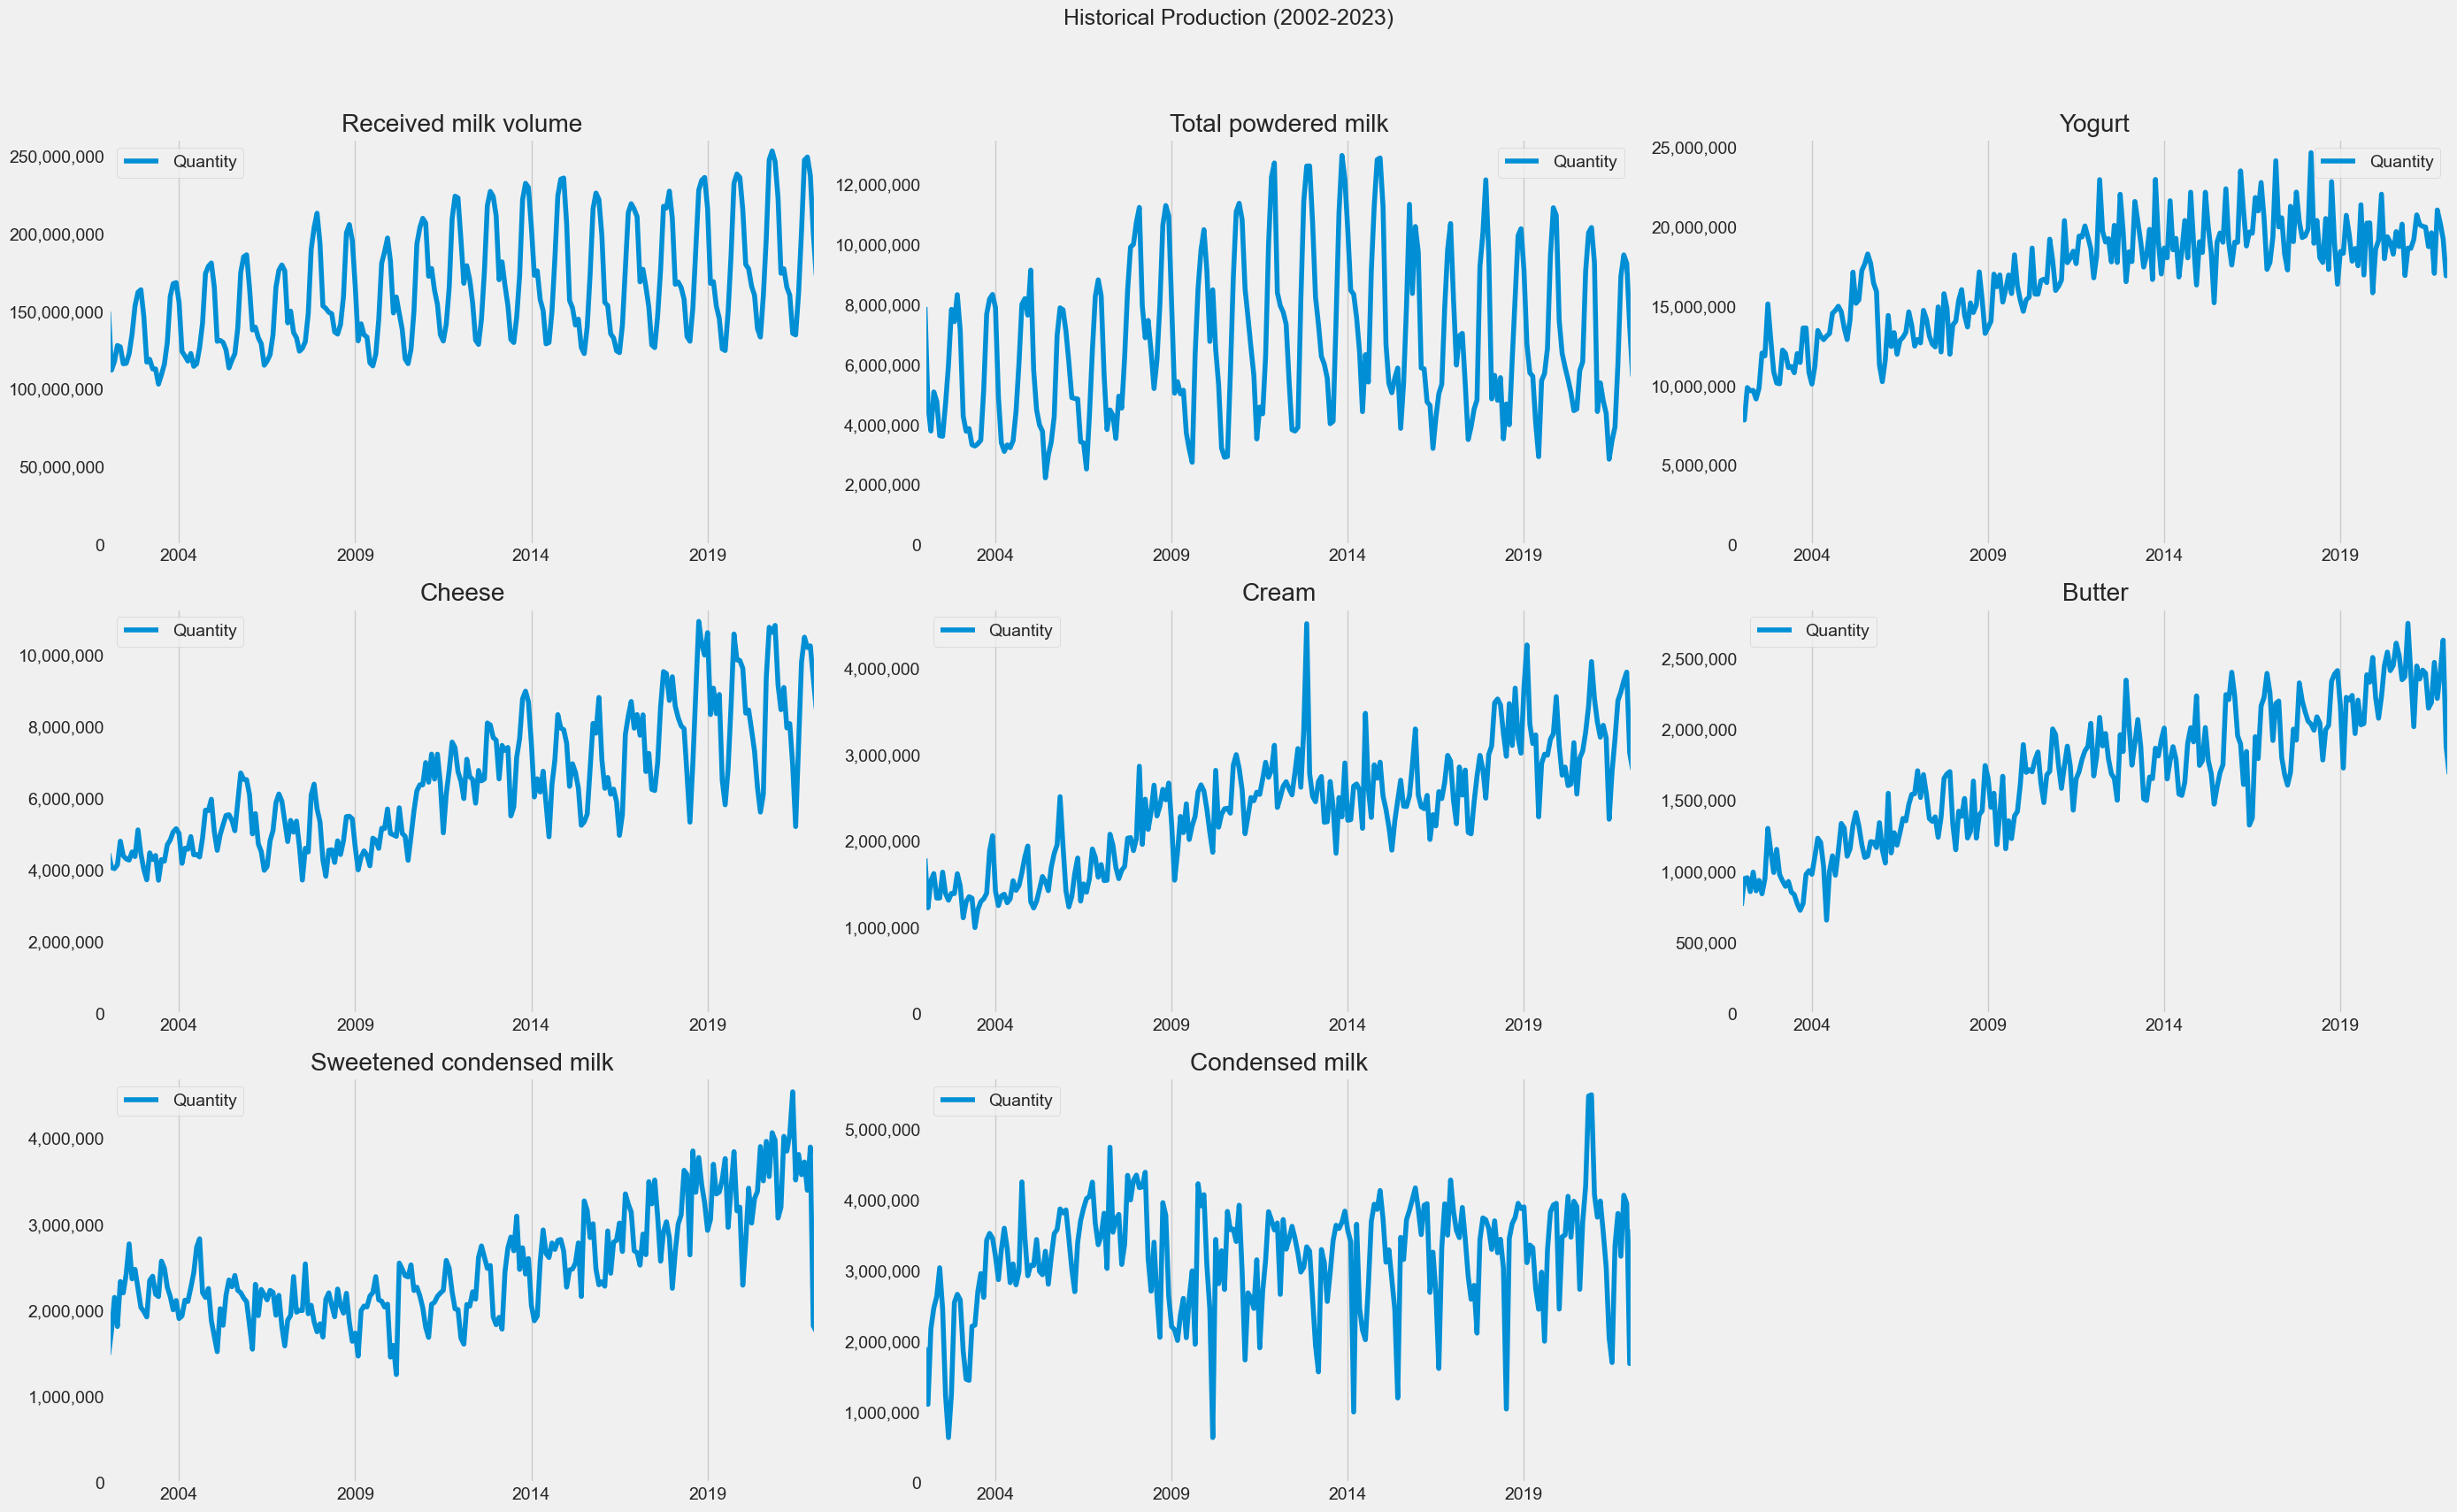

In [17]:
historical_product_plot(df.Product.unique().tolist())

In [21]:
# Create a new column 'Factory' that contains the substring before any hyphen
df['Factory'] = df['Factory_Name'].str.split('-').str[0]

# Remove location from the Factory_Name
#df['Factory_Name_Modified'] = df['Factory_Name'].str.extract(r'^(.*?) -')[0]

df = df.drop(['Factory_Name', 'Area'], axis=1)
# Aggregate the quantities by the modified factory name, year, and product
df = df.groupby(['year_month','Year', 'Month','Factory', 'Product', 'Unity']).agg({'Quantity': 'sum'}).reset_index()

df

year_month  Year  Month                  Factory  \
0        2002-01  2002      1  ALIMENTOS PUERTO VARAS    
1        2002-01  2002      1  ALIMENTOS PUERTO VARAS    
2        2002-01  2002      1  ALIMENTOS PUERTO VARAS    
3        2002-01  2002      1  ALIMENTOS PUERTO VARAS    
4        2002-01  2002      1  ALIMENTOS PUERTO VARAS    
...          ...   ...    ...                      ...   
15289    2023-01  2023      1              WATTS S.A.    
15290    2023-01  2023      1              WATTS S.A.    
15291    2023-01  2023      1              WATTS S.A.    
15292    2023-01  2023      1              WATTS S.A.    
15293    2023-01  2023      1              WATTS S.A.    

                        Product Unity  Quantity  
0                        Butter    Kg      5426  
1                        Cheese    Kg     17711  
2                         Cream    Kg      3525  
3          Received milk volume   Lts    540661  
4           Total powdered milk    Kg     58875  
...                         ...   ...       ...  
15289                     Cream    Kg    162804  
15290      Received milk volume   Lts  24591979  
15291  Sweetened condensed milk    Kg    298231  
15292       Total powdered milk    Kg    969841  
15293                    Yogurt   Lts   1999339  

[15294 rows x 7 columns]

In [22]:
def Total_product_by_factory(product_selected):
    filter_tag = product_selected

    df_product = df[df.Product == filter_tag]

    pivot_product = pd.pivot_table(df_product, values='Quantity', index=['Factory'],
                     aggfunc=np.sum)
    
    pivot_product_filtered = pivot_product[pivot_product.Quantity > 0]
    sort_pivot_product = pivot_product_filtered.sort_values(by = "Quantity", ascending = False)
    
    return sort_pivot_product

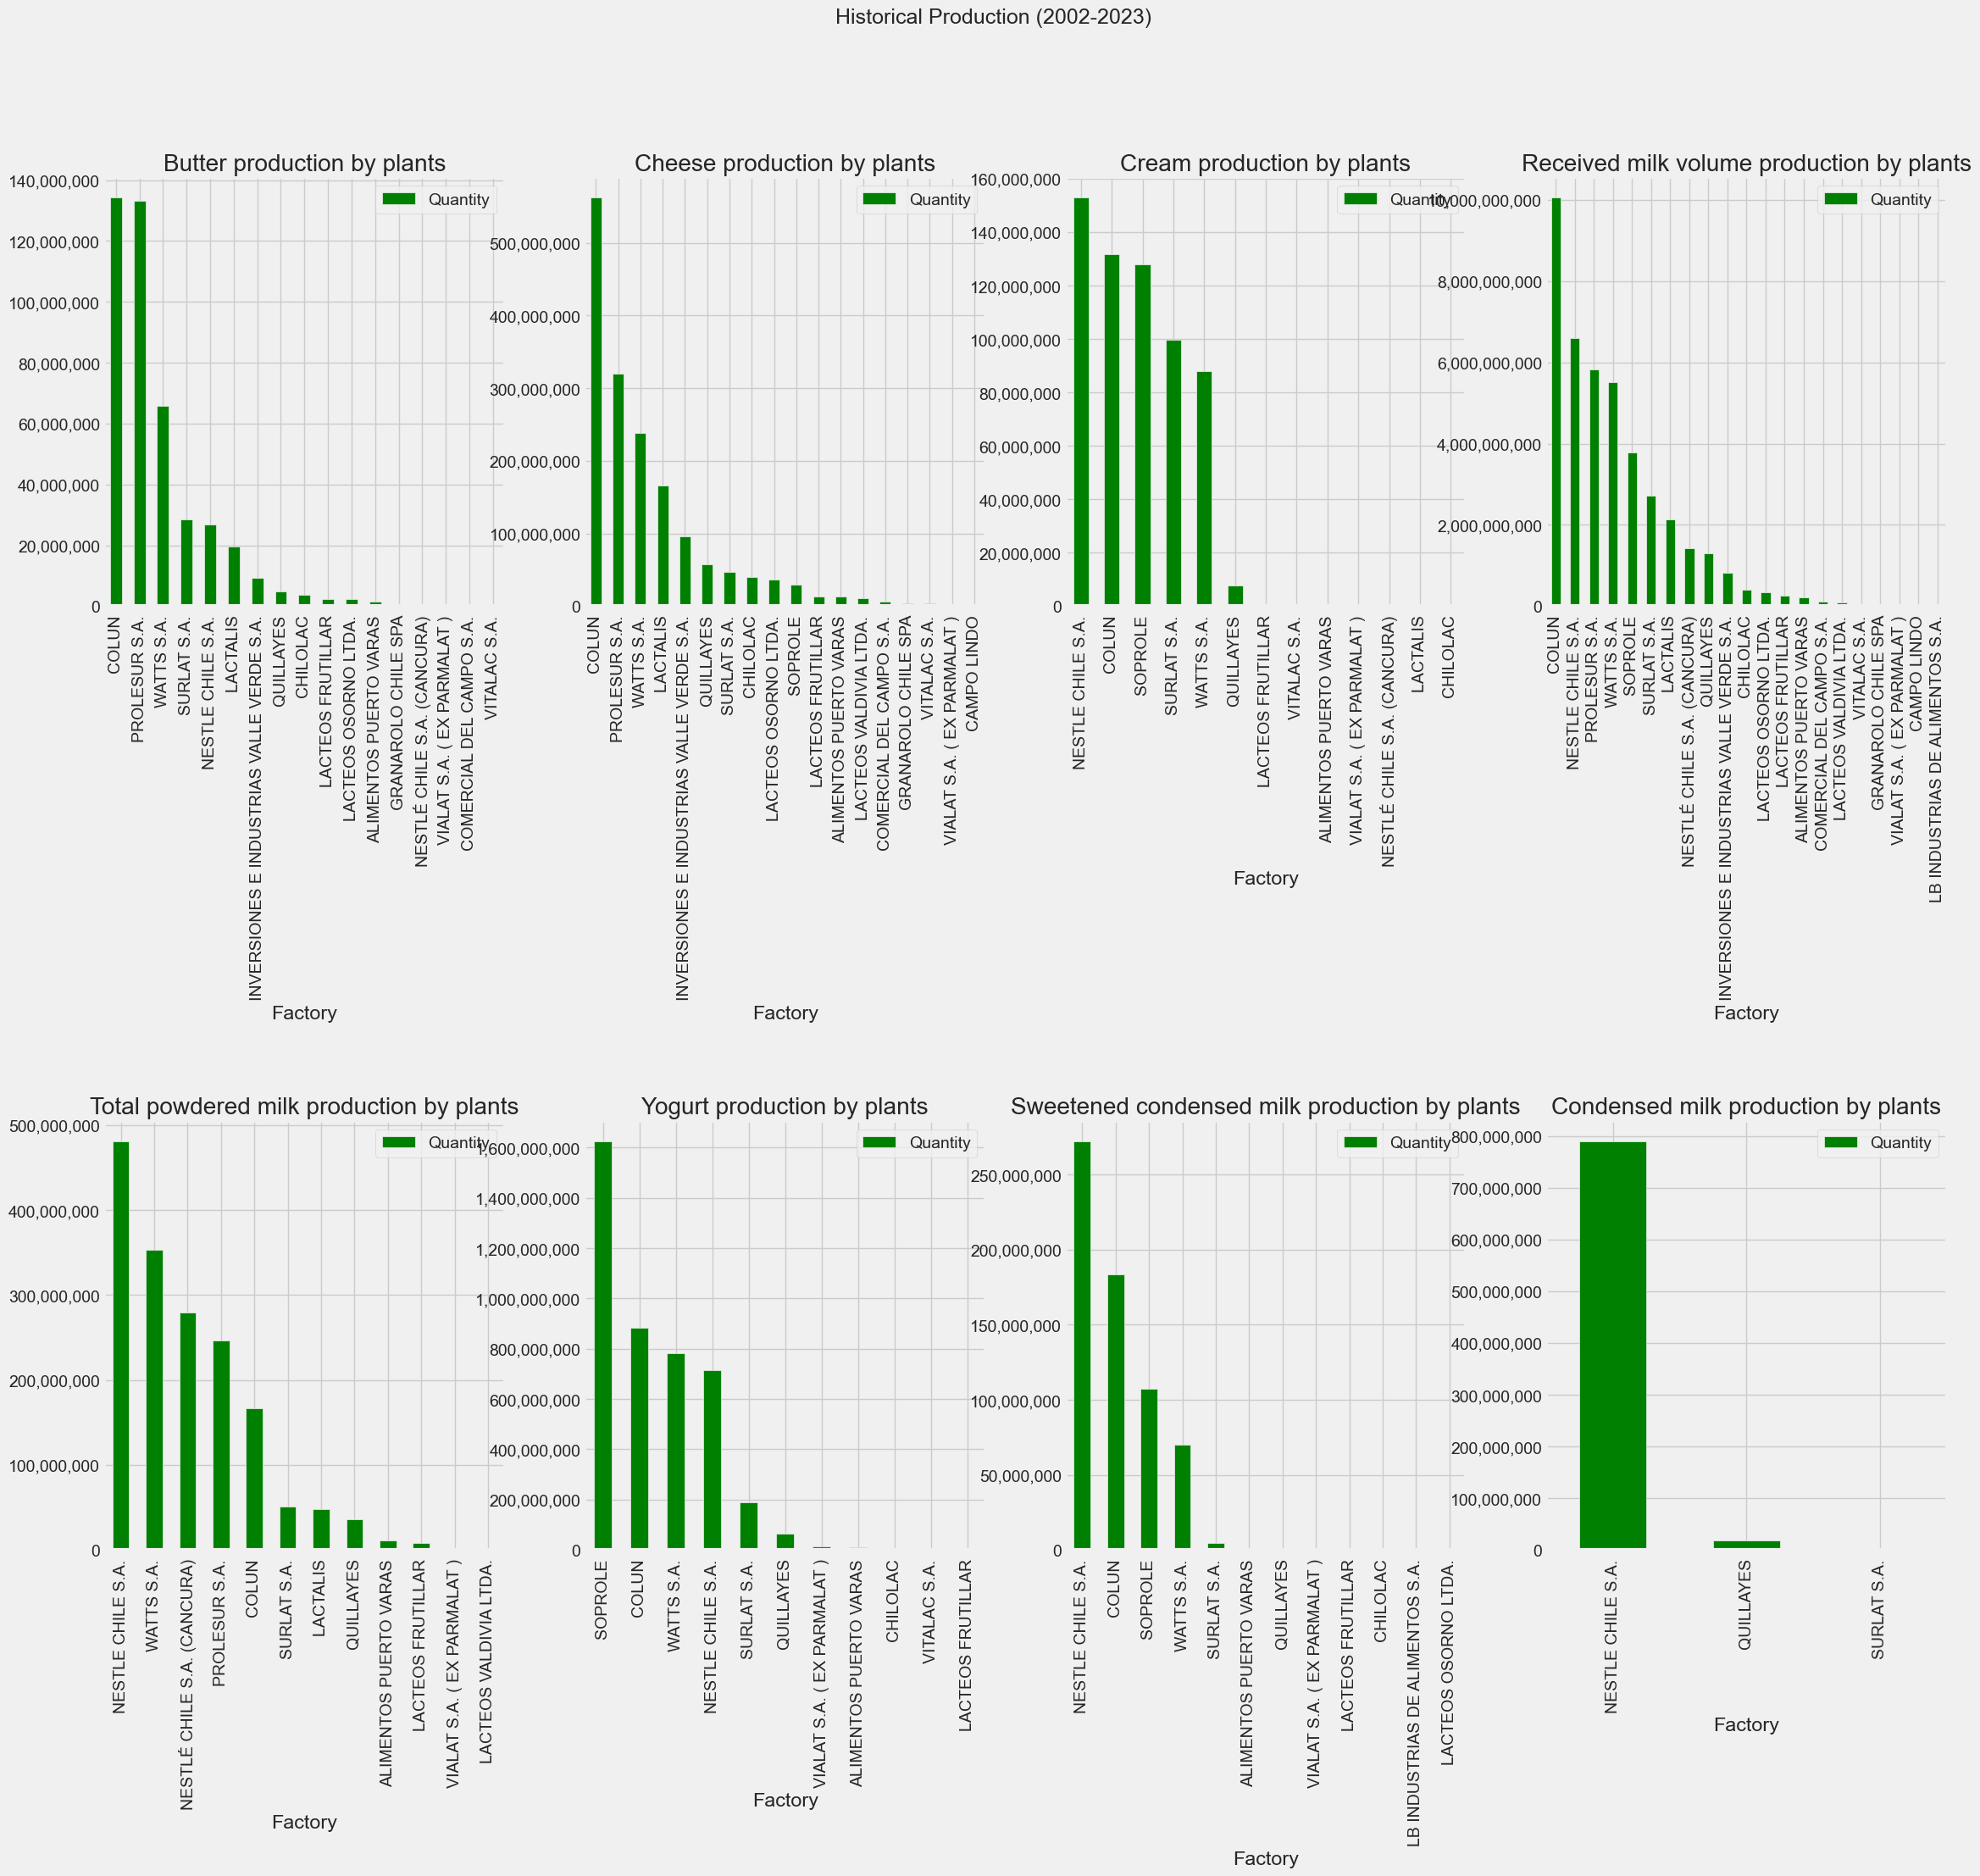

In [23]:
product_list = df.Product.unique().tolist() # List of products
num_plots = len(product_list)
num_rows = 2
num_cols = 4
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(25, 20), squeeze = False)
axs = axs.flatten()


# Adjust spacing between subplots, especially the vertical spacing
fig.subplots_adjust(hspace=1.2)  # Increase the space between rows; adjust this value as needed


fig.suptitle('Historical Production (2002-2023)', fontsize=18)

for i, var in enumerate(product_list):
    table_factory = Total_product_by_factory(var)
    table_factory.plot(kind = "bar", title = f'{var} production by plants', color = "green", ax=axs[i])
    plot_row = math.floor(i / num_cols)
    plot_col = i % num_cols
    axs[i].get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    

# remove unused axes
if num_plots < num_rows * num_cols:
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axs[i])


### *Juntar bases totales*

In [292]:
df2 = pd.read_csv('Base productos lacteos 2023-2024.csv')
df2

Year  Factory_Name                   Product Unity Month     Quantity
0    2023  Total Plants      Received milk volume   Lts   Jan  181.610.490
1    2023  Total Plants       Total powdered milk    Kg   Jan    5.917.603
2    2023  Total Plants                    Yogurt   Lts   Jan   16.205.180
3    2023  Total Plants                    Cheese    Kg   Jan    7.942.511
4    2023  Total Plants                     Cream    Kg   Jan    3.014.901
..    ...           ...                       ...   ...   ...          ...
115  2024  Total Plants                    Cheese    Kg   Mar    7.417.892
116  2024  Total Plants                     Cream    Kg   Mar    3.067.012
117  2024  Total Plants                    Butter    Kg   Mar    2.380.774
118  2024  Total Plants            Condensed milk    Kg   Mar    2.413.242
119  2024  Total Plants  Sweetened condensed milk    Kg   Mar    2.755.774

[120 rows x 6 columns]

In [293]:
# Ensure the Month column is numeric (mapping month names to numbers if necessary)
month_code = {
    "Jan" : 1,
    "Feb": 2, 
    "Mar": 3,
    "Abril": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}
df2['Month'] = df2['Month'].replace(month_code)

# Create a 'year_month' column directly by combining 'Year' and 'Month' into a datetime
df2['year_month'] = pd.to_datetime(df2[['Year', 'Month']].assign(Day=1))

# Convert to a Period if necessary (for month-year format without days)
df2['year_month'] = df2['year_month'].dt.to_period('M')

# Reorder columns to match the original DataFrame's order
df2 = df2[['year_month','Year', 'Month', 'Factory_Name', 'Product', 'Unity', 'Quantity']]

# Convert the column to numeric
df2['Quantity'] = df2['Quantity'].str.replace('.', '')

df2['Quantity'] = df2['Quantity'].astype('Int64')

df2

year_month  Year  Month  Factory_Name                   Product Unity  \
0      2023-01  2023      1  Total Plants      Received milk volume   Lts   
1      2023-01  2023      1  Total Plants       Total powdered milk    Kg   
2      2023-01  2023      1  Total Plants                    Yogurt   Lts   
3      2023-01  2023      1  Total Plants                    Cheese    Kg   
4      2023-01  2023      1  Total Plants                     Cream    Kg   
..         ...   ...    ...           ...                       ...   ...   
115    2024-03  2024      3  Total Plants                    Cheese    Kg   
116    2024-03  2024      3  Total Plants                     Cream    Kg   
117    2024-03  2024      3  Total Plants                    Butter    Kg   
118    2024-03  2024      3  Total Plants            Condensed milk    Kg   
119    2024-03  2024      3  Total Plants  Sweetened condensed milk    Kg   

      Quantity  
0    181610490  
1      5917603  
2     16205180  
3      7942511  
4      3014901  
..         ...  
115    7417892  
116    3067012  
117    2380774  
118    2413242  
119    2755774  

[120 rows x 7 columns]

In [294]:
df3 = pd.read_csv('Total liquid milk 2013-2024.csv')
df3

Year  Factory_Name Month            Product Unity    Quantity
0    2013  Total Plants   Jan  Total Liquid Milk   Lts  29.601.098
1    2013  Total Plants   Feb  Total Liquid Milk   Lts  30.824.745
2    2013  Total Plants   Mar  Total Liquid Milk   Lts  36.595.537
3    2013  Total Plants   Apr  Total Liquid Milk   Lts  38.287.555
4    2013  Total Plants   May  Total Liquid Milk   Lts  33.272.434
..    ...           ...   ...                ...   ...         ...
130  2023  Total Plants   Nov  Total Liquid Milk   Lts  48.467.465
131  2023  Total Plants   Dec  Total Liquid Milk   Lts  44.786.341
132  2024  Total Plants   Jan  Total Liquid Milk   Lts  39.963.642
133  2024  Total Plants   Feb  Total Liquid Milk   Lts  37.740.628
134  2024  Total Plants   Mar  Total Liquid Milk   Lts  42.686.731

[135 rows x 6 columns]

In [295]:
# Ensure the Month column is numeric (mapping month names to numbers if necessary)
month_code = {
    "Jan" : 1,
    "Feb": 2, 
    "Mar": 3,
    "Apr": 4,
    "May": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Oct": 10,
    "Nov": 11,
    "Dec": 12
}
df3['Month'] = df3['Month'].replace(month_code)

# Create a 'year_month' column directly by combining 'Year' and 'Month' into a datetime
df3['year_month'] = pd.to_datetime(df3[['Year', 'Month']].assign(Day=1))

# Convert to a Period if necessary (for month-year format without days)
df3['year_month'] = df3['year_month'].dt.to_period('M')

# Reorder columns to match the original DataFrame's order
df3 = df3[['year_month','Year', 'Month', 'Factory_Name', 'Product', 'Unity', 'Quantity']]

# Convert the column to numeric
df3['Quantity'] = df3['Quantity'].str.replace('.', '')

df3['Quantity'] = df3['Quantity'].astype('Int64')

df3

year_month  Year  Month  Factory_Name            Product Unity  Quantity
0      2013-01  2013      1  Total Plants  Total Liquid Milk   Lts  29601098
1      2013-02  2013      2  Total Plants  Total Liquid Milk   Lts  30824745
2      2013-03  2013      3  Total Plants  Total Liquid Milk   Lts  36595537
3      2013-04  2013      4  Total Plants  Total Liquid Milk   Lts  38287555
4      2013-05  2013      5  Total Plants  Total Liquid Milk   Lts  33272434
..         ...   ...    ...           ...                ...   ...       ...
130    2023-11  2023     11  Total Plants  Total Liquid Milk   Lts  48467465
131    2023-12  2023     12  Total Plants  Total Liquid Milk   Lts  44786341
132    2024-01  2024      1  Total Plants  Total Liquid Milk   Lts  39963642
133    2024-02  2024      2  Total Plants  Total Liquid Milk   Lts  37740628
134    2024-03  2024      3  Total Plants  Total Liquid Milk   Lts  42686731

[135 rows x 7 columns]

In [296]:
# Group by Year, Product, and Month and sum the Quantity
aggregated_df = df.groupby(['year_month','Year', 'Month', 'Product', 'Unity']).Quantity.sum().reset_index()

# Add a new column for 'Factory_Name' with a common label, e.g., 'All Factories'
aggregated_df['Factory_Name'] = 'Total Plants'

# Reorder columns to match the original DataFrame's order
aggregated_df = aggregated_df[['year_month','Year', 'Month', 'Factory_Name', 'Product', 'Unity', 'Quantity']]

# Condition: Drop rows where 'Quantity' is 0
condition = (aggregated_df['Year'] == 2023)

# Inverting the condition to keep rows that do not meet the condition

aggregated_df = aggregated_df[~condition]

aggregated_df

year_month  Year  Month  Factory_Name                   Product Unity  \
0       2002-01  2002      1  Total Plants                    Butter    Kg   
1       2002-01  2002      1  Total Plants                    Cheese    Kg   
2       2002-01  2002      1  Total Plants            Condensed milk    Kg   
3       2002-01  2002      1  Total Plants                     Cream    Kg   
4       2002-01  2002      1  Total Plants      Received milk volume   Lts   
...         ...   ...    ...           ...                       ...   ...   
2011    2022-12  2022     12  Total Plants                     Cream    Kg   
2012    2022-12  2022     12  Total Plants      Received milk volume   Lts   
2013    2022-12  2022     12  Total Plants  Sweetened condensed milk    Kg   
2014    2022-12  2022     12  Total Plants       Total powdered milk    Kg   
2015    2022-12  2022     12  Total Plants                    Yogurt   Lts   

       Quantity  
0        759525  
1       4475498  
2       1921020  
3       1799386  
4     149680733  
...         ...  
2011    3468190  
2012  228449671  
2013    2798228  
2014    8903216  
2015   16983834  

[2016 rows x 7 columns]

### *Base con totales*

In [317]:
total_df = pd.concat([aggregated_df, df2], ignore_index=True)
#total_df = pd.concat([total_df, df3], ignore_index=True)

total_df = total_df.groupby(['year_month','Year', 'Month', 'Product', 'Unity']).Quantity.sum().reset_index()

total_df2 = total_df.copy()

total_df

year_month  Year  Month                   Product Unity   Quantity
0       2002-01  2002      1                    Butter    Kg     759525
1       2002-01  2002      1                    Cheese    Kg    4475498
2       2002-01  2002      1            Condensed milk    Kg    1921020
3       2002-01  2002      1                     Cream    Kg    1799386
4       2002-01  2002      1      Received milk volume   Lts  149680733
...         ...   ...    ...                       ...   ...        ...
2131    2024-03  2024      3                     Cream    Kg    3067012
2132    2024-03  2024      3      Received milk volume   Lts  165805522
2133    2024-03  2024      3  Sweetened condensed milk    Kg    2755774
2134    2024-03  2024      3       Total powdered milk    Kg    4913198
2135    2024-03  2024      3                    Yogurt   Lts   20878022

[2136 rows x 6 columns]

In [ ]:
#df['year_month'] = pd.to_datetime(df['year_month'])
# Set 'year_month' as the DataFrame index
total_df.set_index('year_month', inplace=True)
total_df.index = total_df.index.to_timestamp(freq='M')
    
total_df.info()

total_df

### *Analyze each Product Serie*

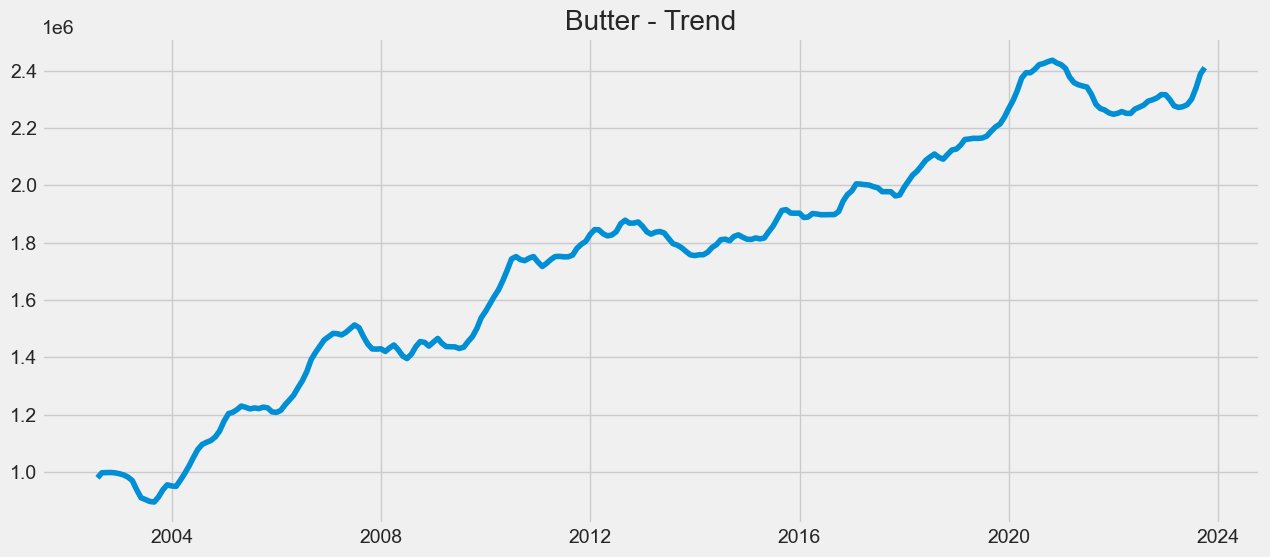

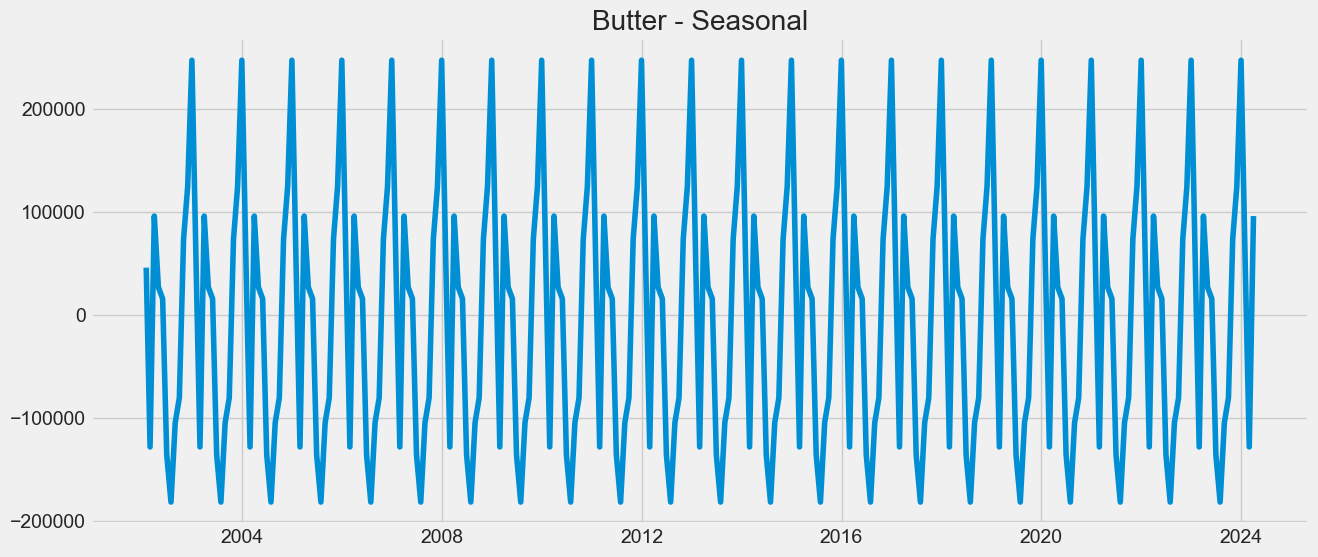

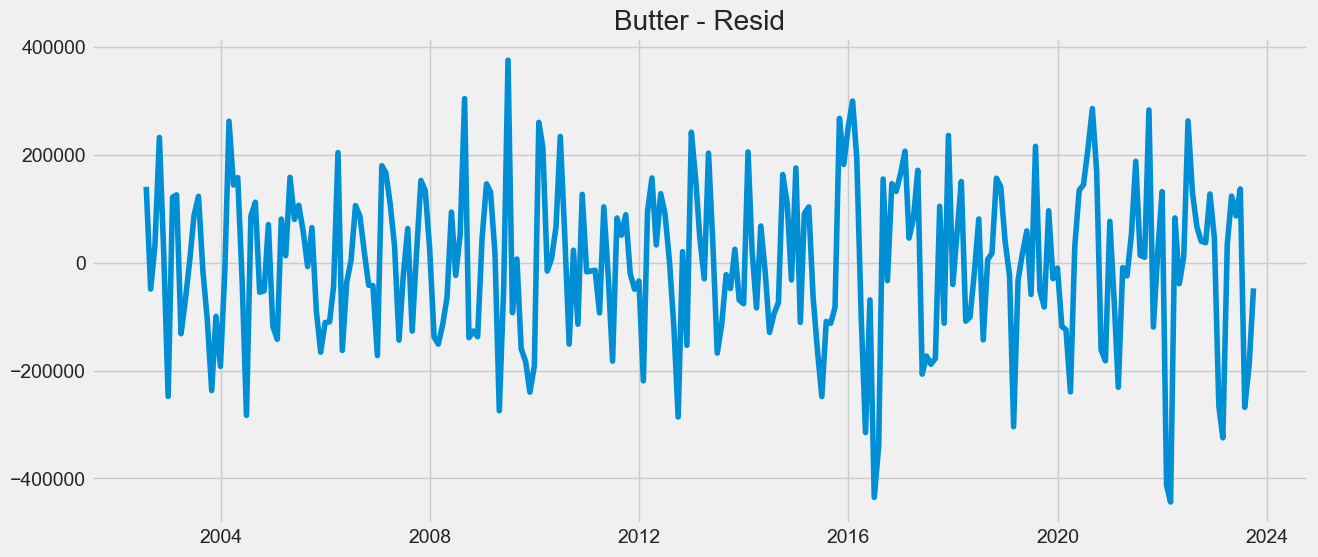

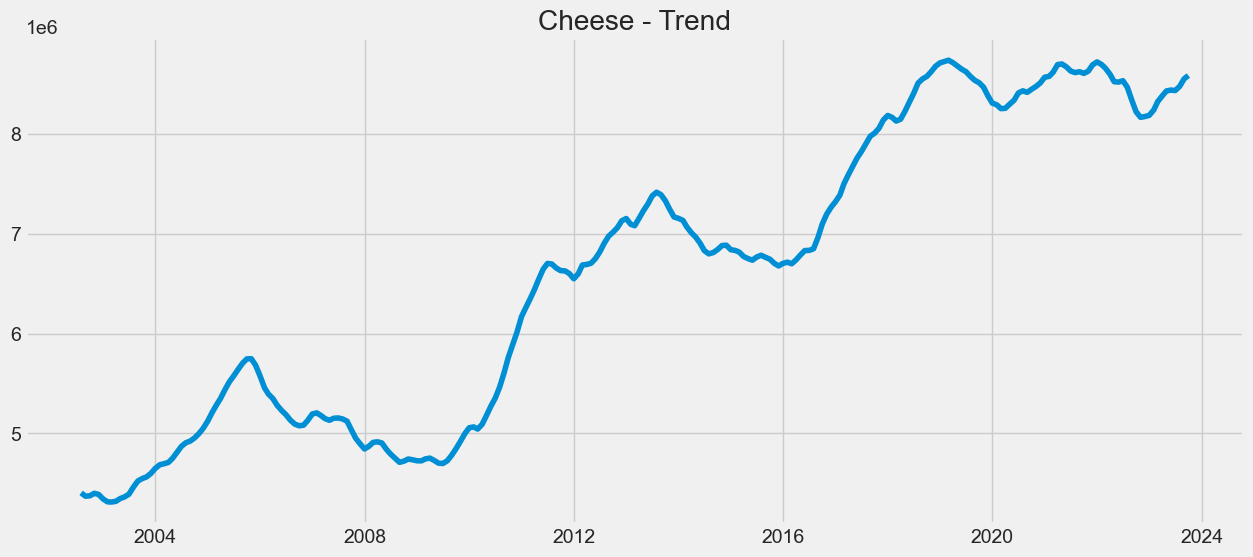

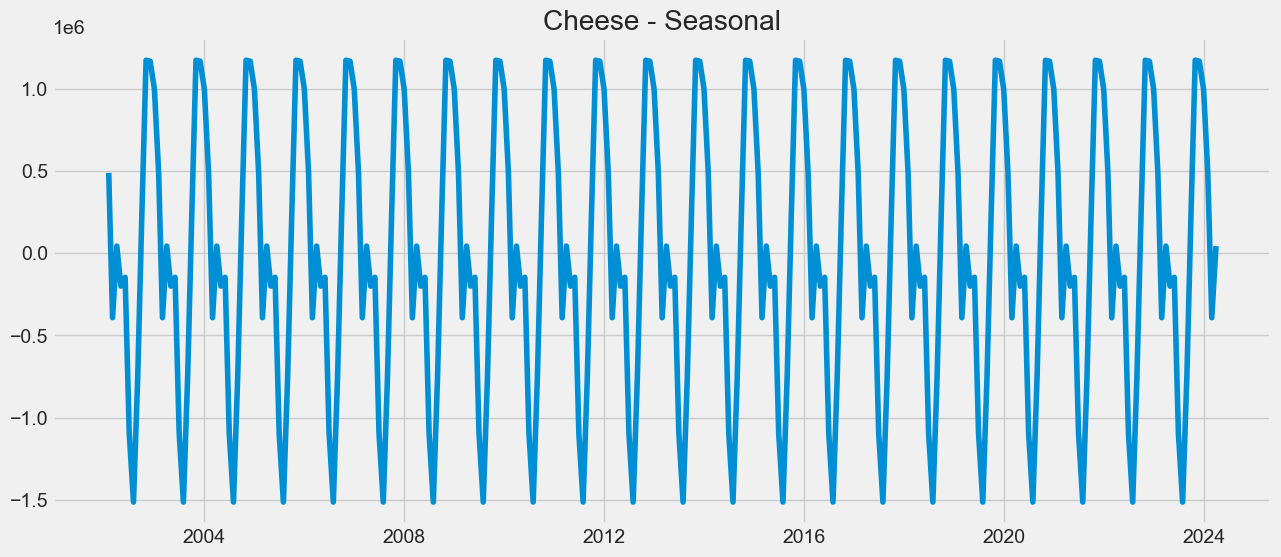

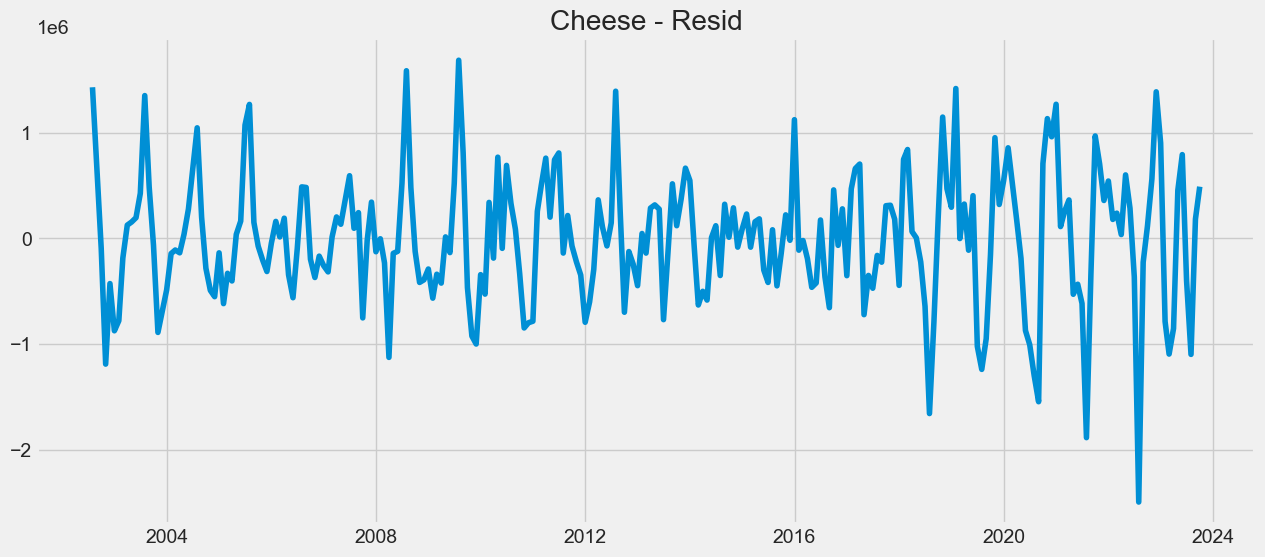

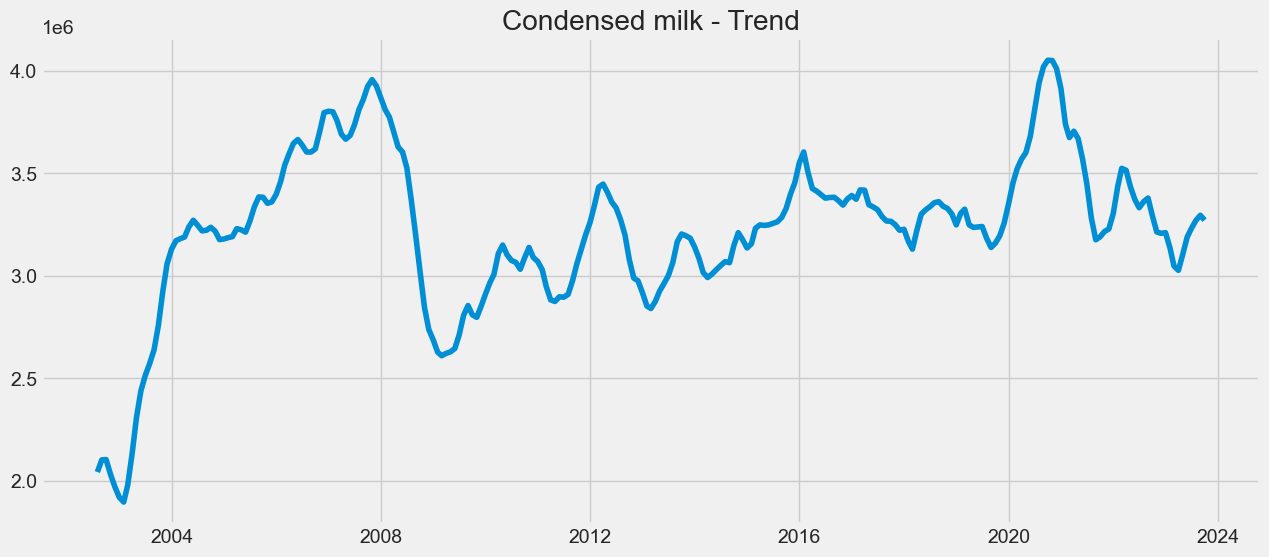

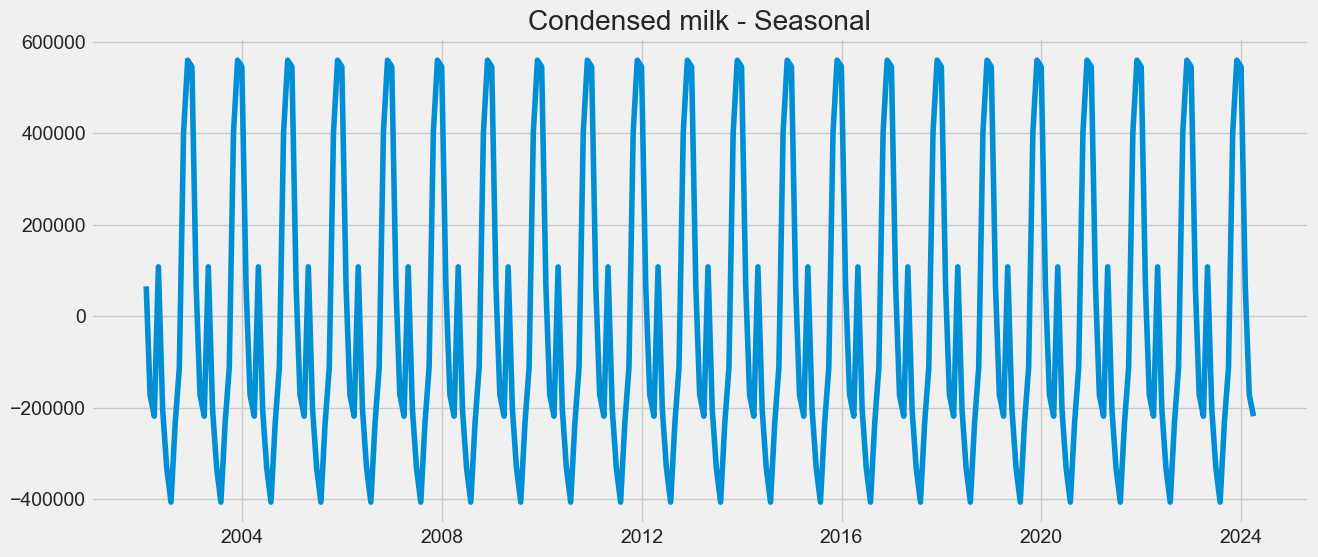

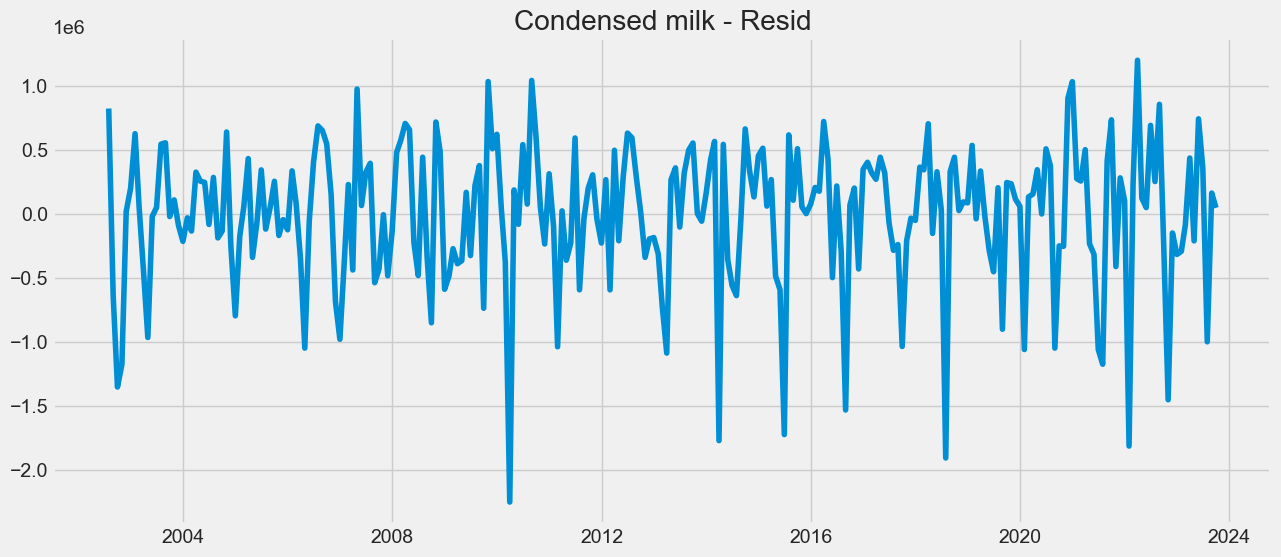

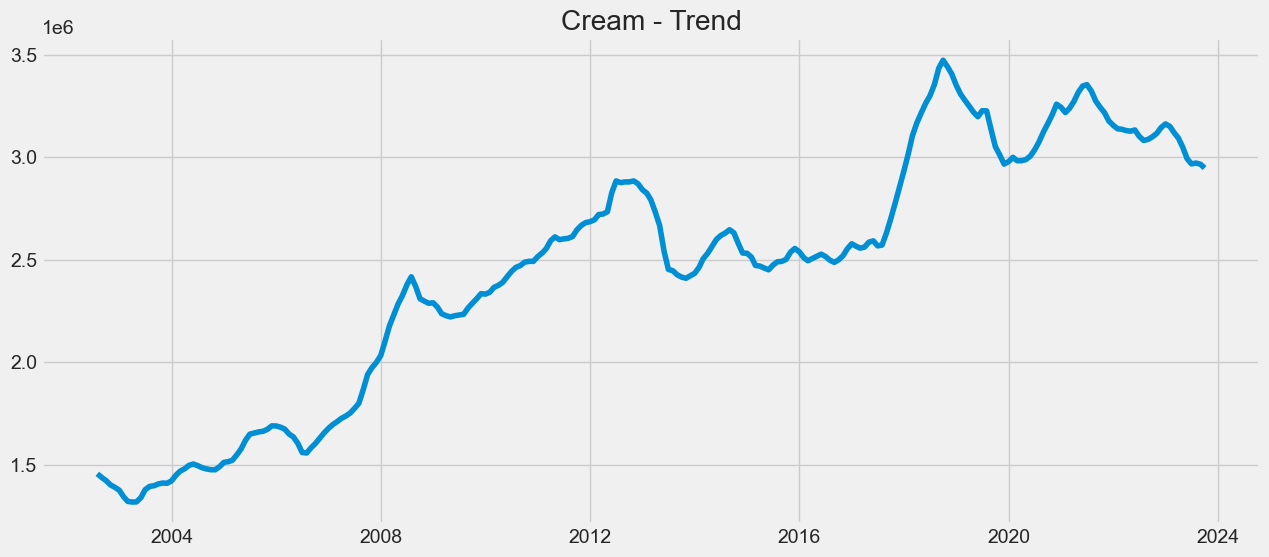

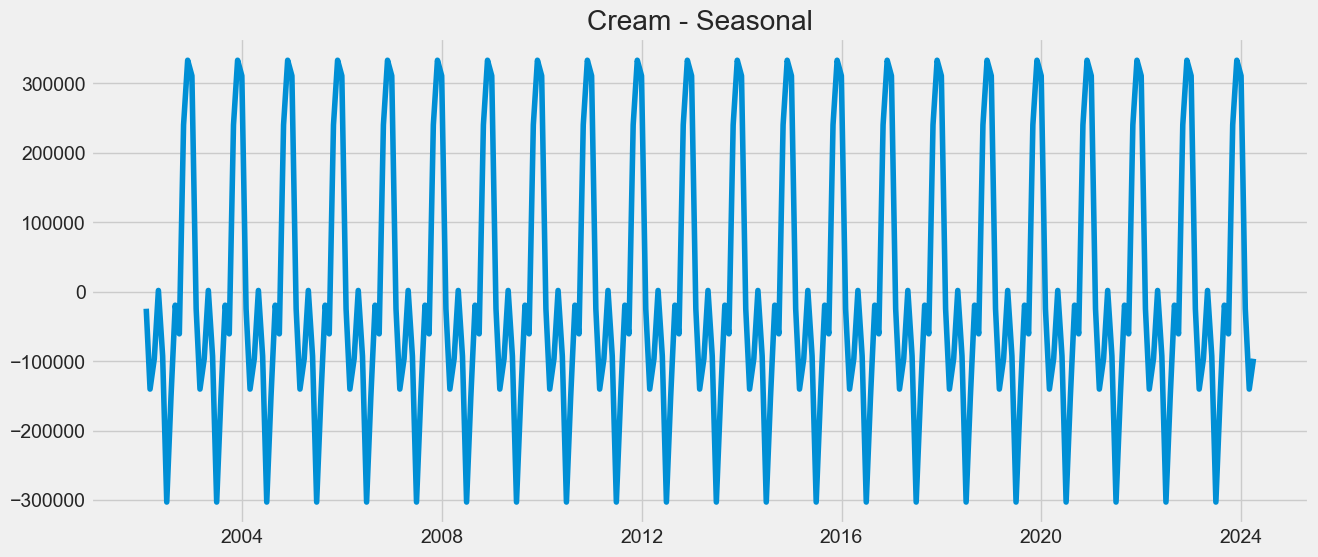

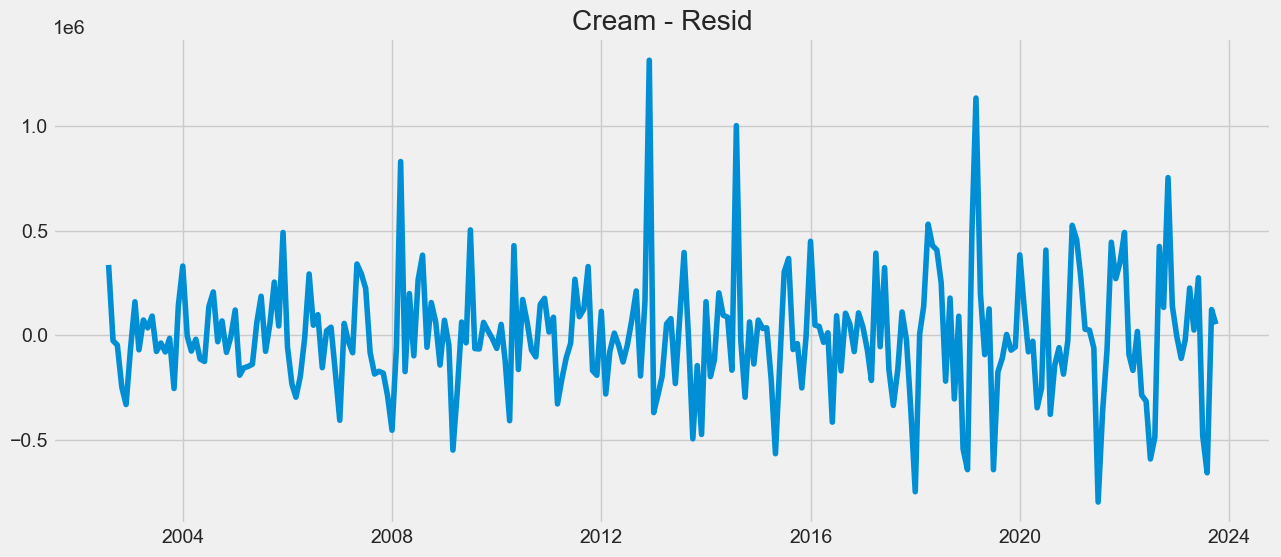

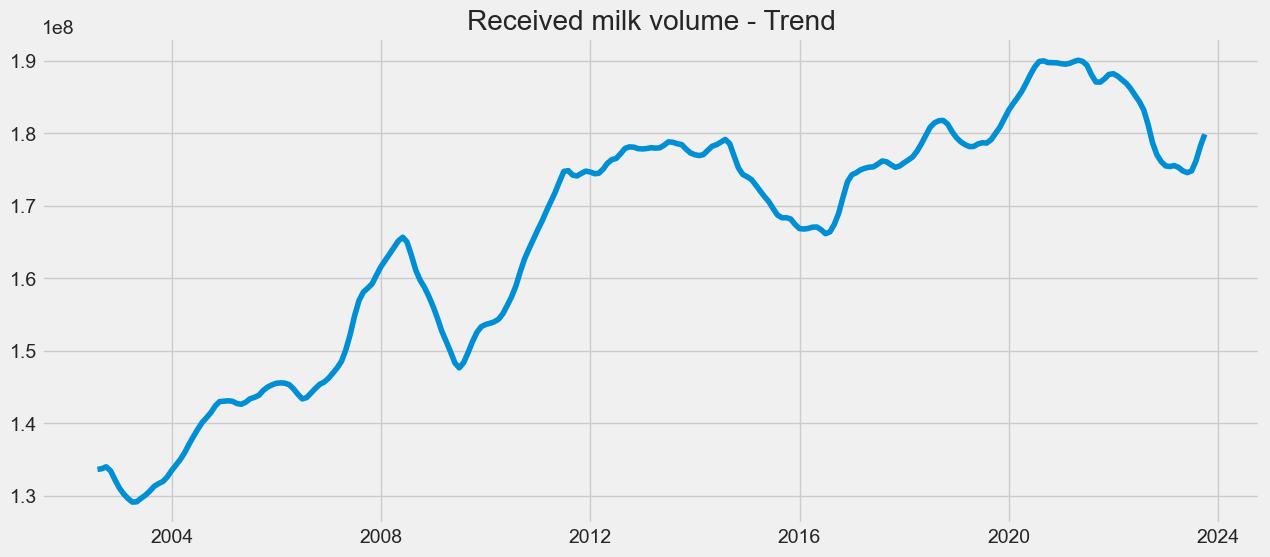

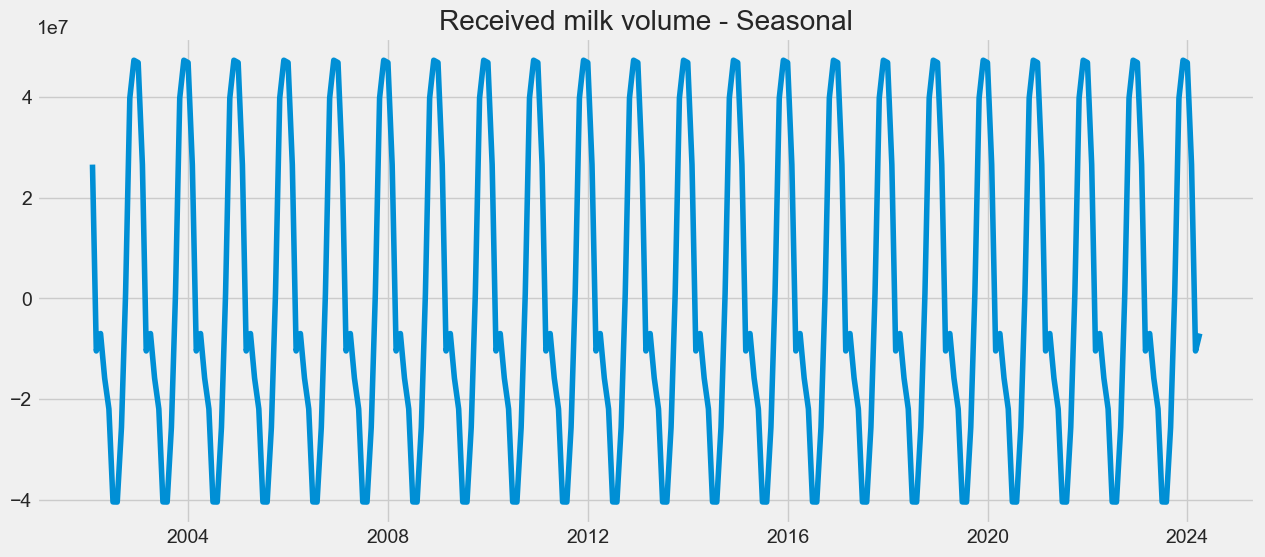

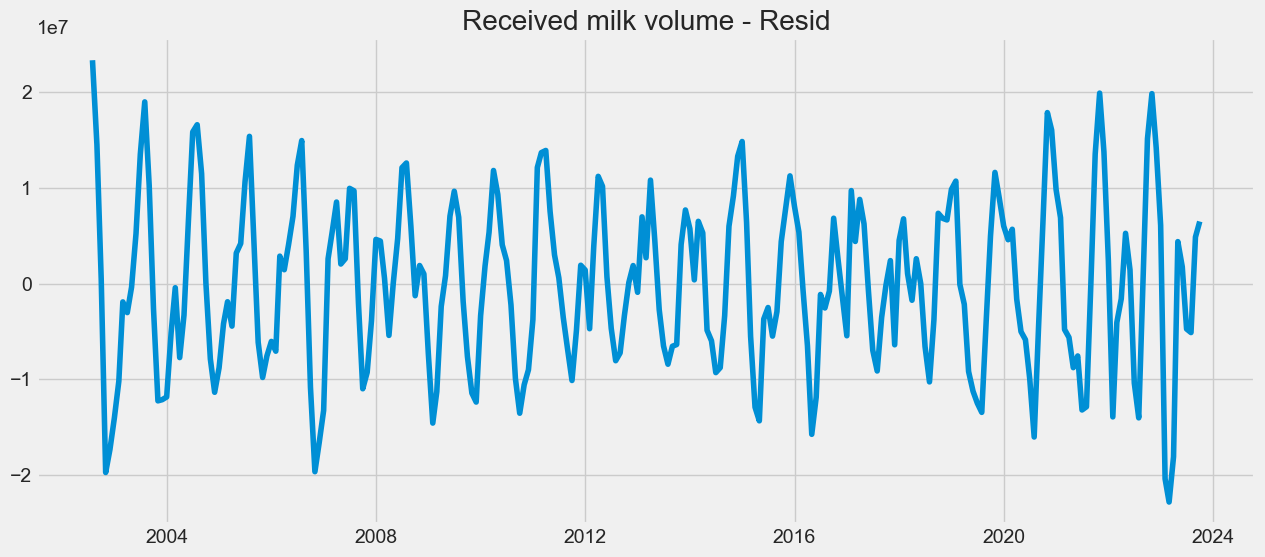

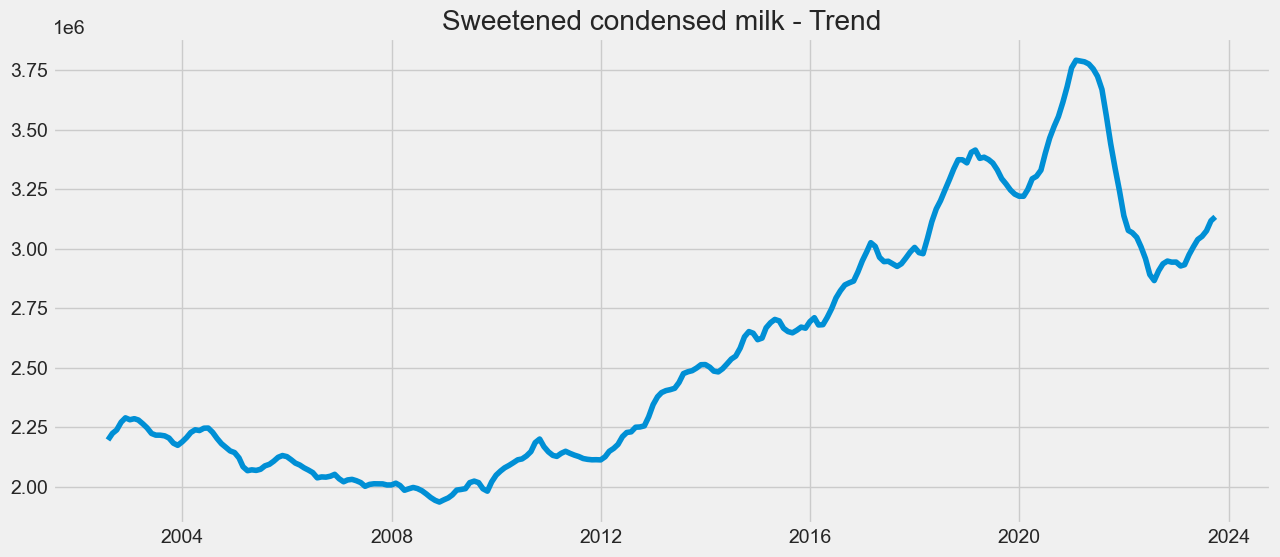

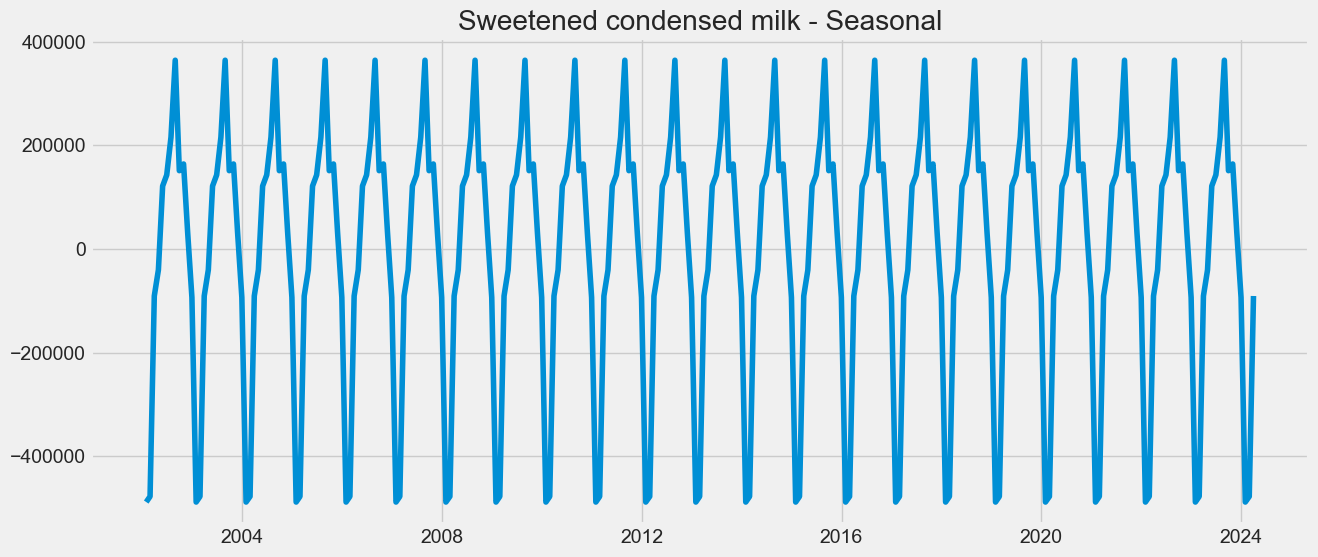

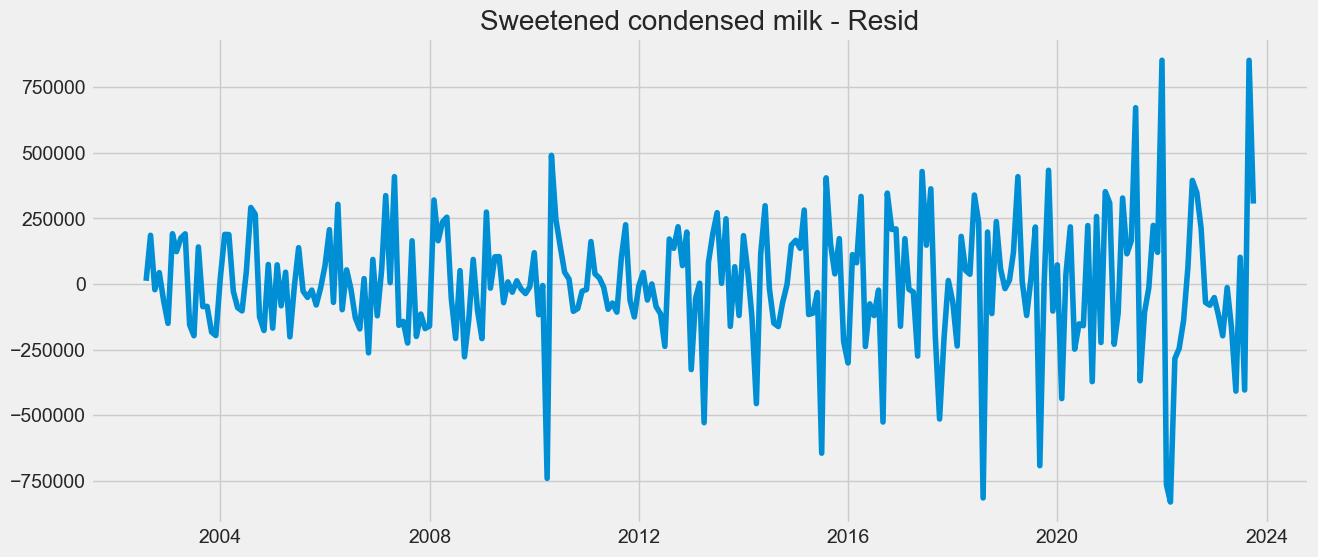

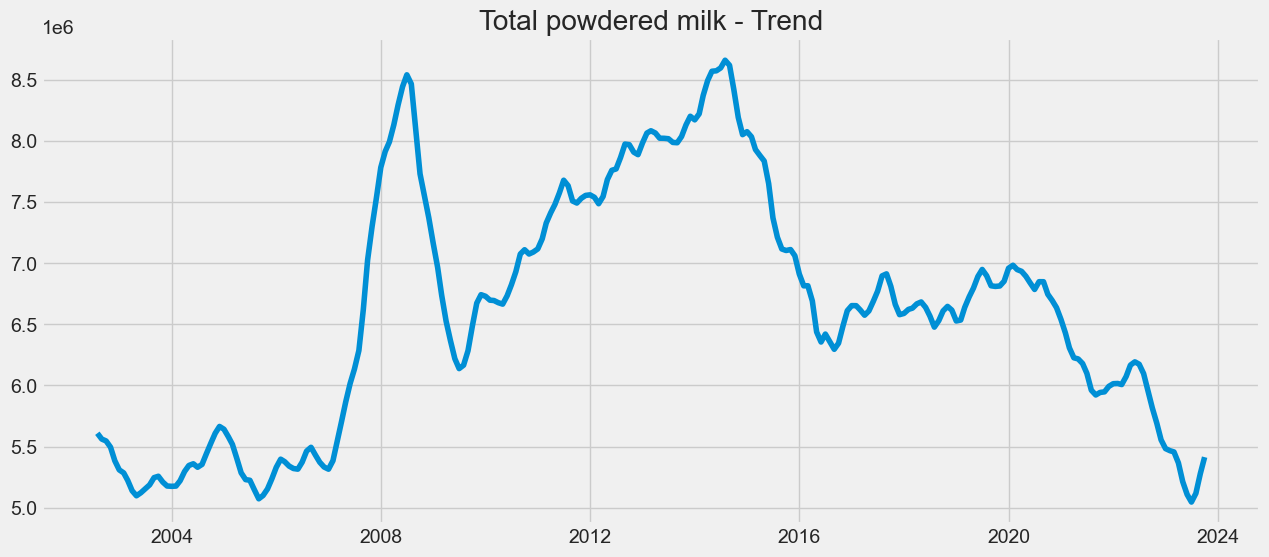

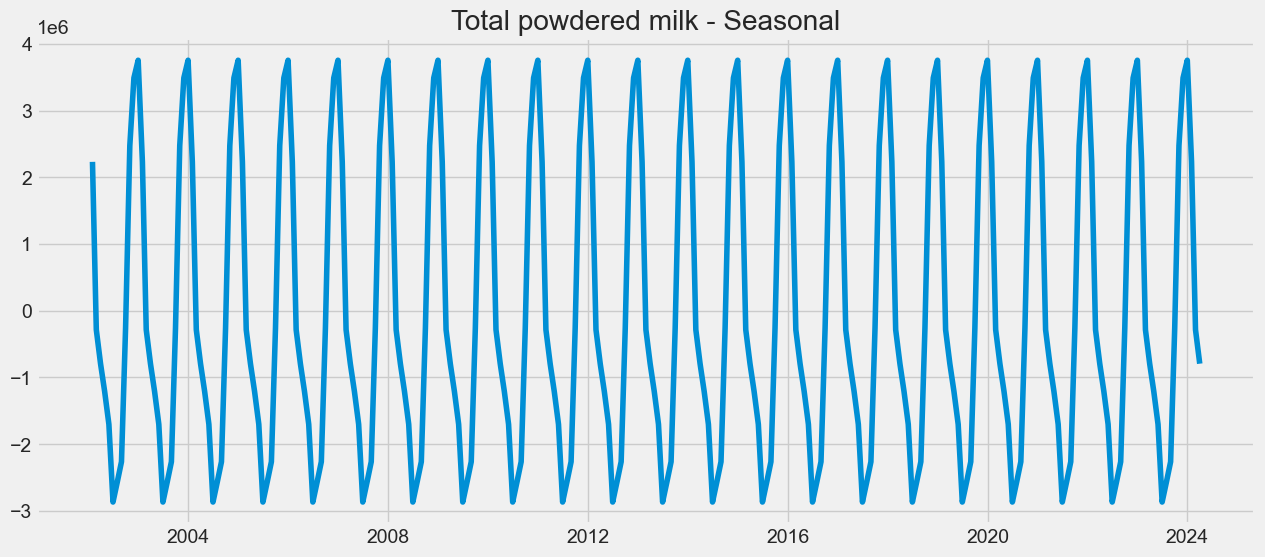

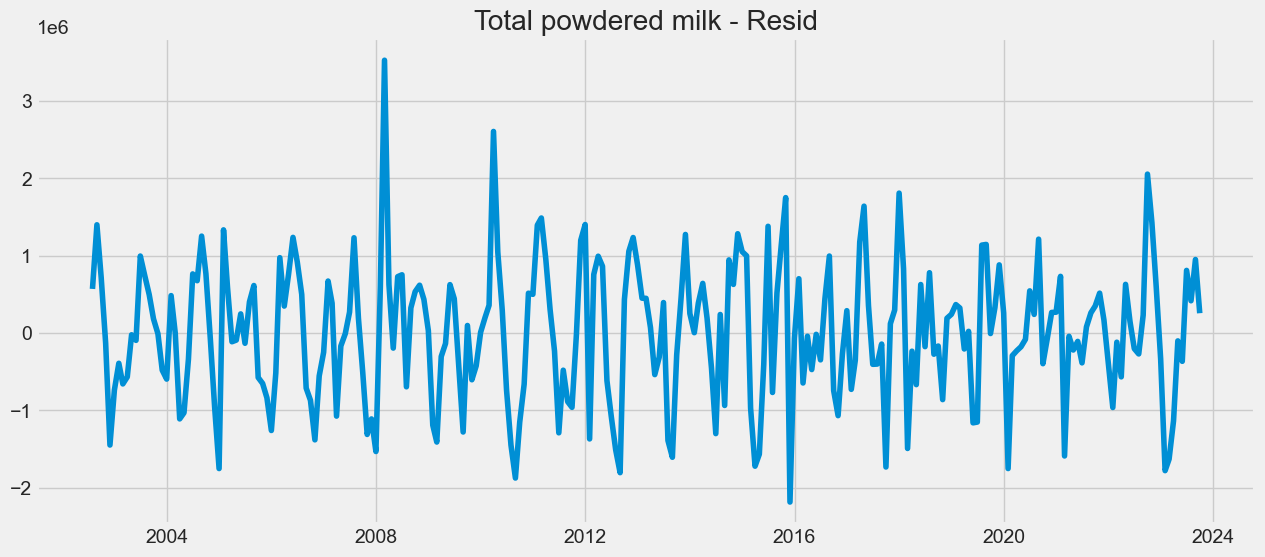

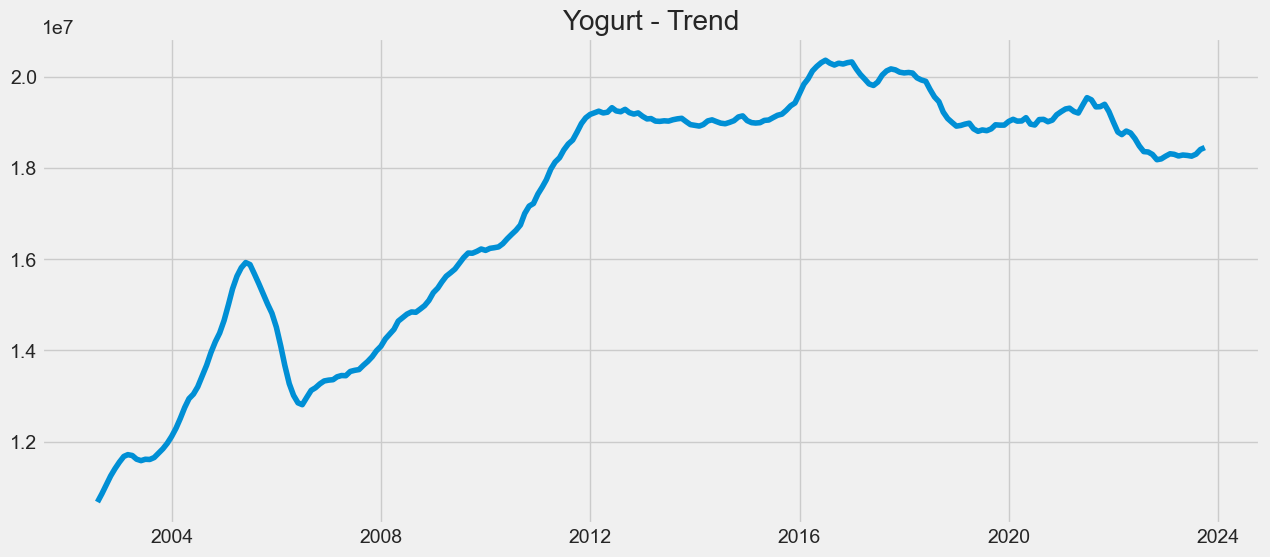

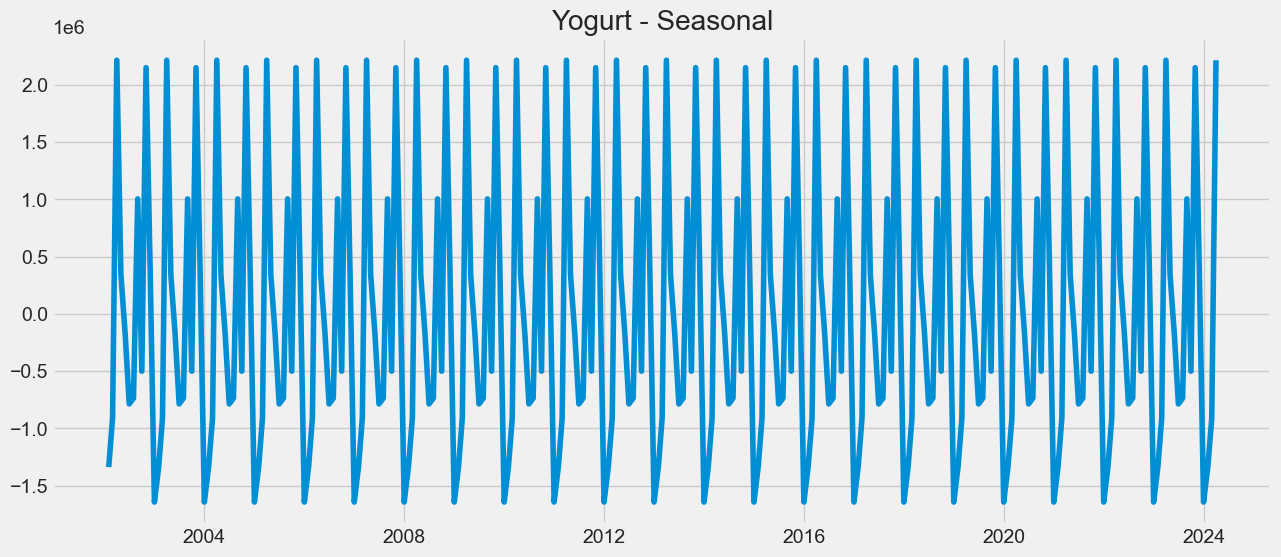

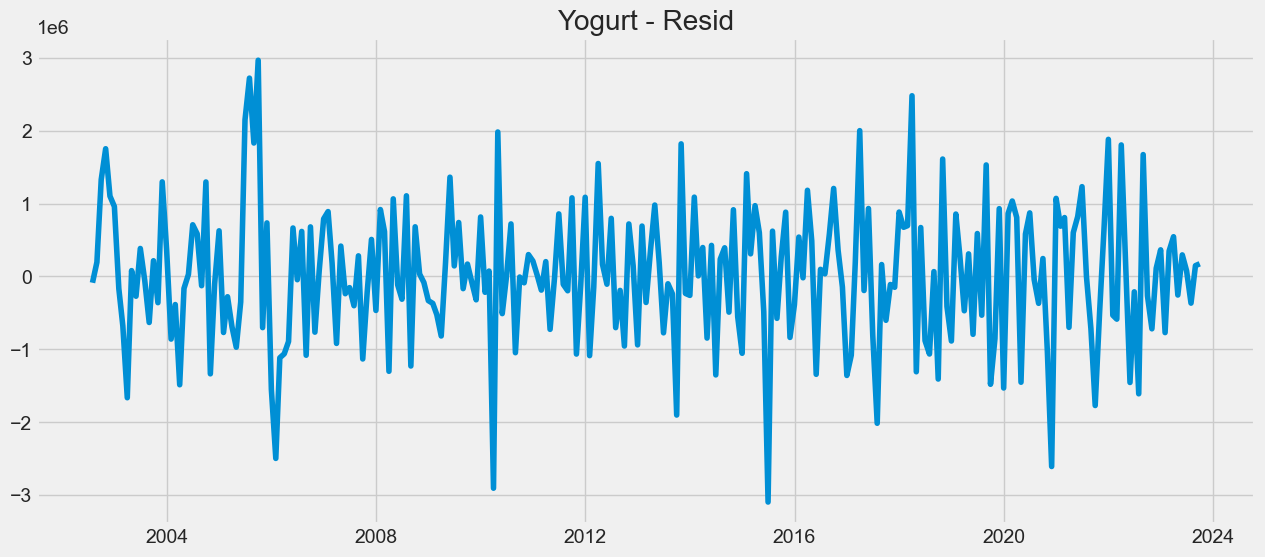

In [298]:
for product in total_df.Product.unique():
    # Filter data for the current product
    product_data = total_df[total_df['Product'] == product]['Quantity']  # Assuming a 'Quantity' column exists

    # Check if there's enough data to decompose
    if len(product_data.dropna()) < 24:  # Generally, need at least 2 years of monthly data to see patterns
        print(f"Not enough data to decompose for {product}: only {len(product_data.dropna())} data points available.")
        continue
    
    # Decompose the time series
    result = seasonal_decompose(product_data.dropna(), model='additive', period=12)  # Assume monthly data with annual seasonality

    # Plot each component in a separate figure with a larger size
    components = ['trend', 'seasonal', 'resid']
    for component in components:
        plt.figure(figsize=(14, 6))  # Adjust size as needed
        plt.plot(result.__getattribute__(component))
        plt.title(f'{product} - {component.capitalize()}')
        plt.grid(True)  # Optional: Add grid for better readability
        plt.show()

In [299]:
for product in total_df.Product.unique():
    # Filter data for the current product
    product_data = total_df[total_df['Product'] == product]['Quantity']  # Assuming a 'Quantity' column exists
    # Perform Dickey-Fuller test
    test_result = adfuller(product_data.dropna())  # Ensure no NaN values

    # Print results
    print('ADF Statistic: %f' % test_result[0])
    print('p-value: %f' % test_result[1])
    print('Critical Values:')
    for key, value in test_result[4].items():
        print('\t%s: %.3f' % (key, value))

    # Based on the p-value, determine stationarity
    if test_result[1] > 0.05:
        print(f'Series {product} is not stationary')
    else:
        print(f'Series {product} is stationary')

ADF Statistic: -0.922529
p-value: 0.780463
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
Series Butter is not stationary
ADF Statistic: -1.066788
p-value: 0.728133
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Series Cheese is not stationary
ADF Statistic: -9.250805
p-value: 0.000000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573
Series Condensed milk is stationary
ADF Statistic: -1.655437
p-value: 0.454206
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
Series Cream is not stationary
ADF Statistic: -2.007786
p-value: 0.283170
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Series Received milk volume is not stationary
ADF Statistic: -0.862450
p-value: 0.800087
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
Series Sweetened condensed milk is not stationary
ADF Statistic: -2.352258
p-value: 0.155667
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Series Total powdered milk is not stationary
ADF Statistic: -2.314602
p-value: 0.167302
Critic

In [300]:
#Creating global variables for each product
'''for product in total_df.Product.unique():
    # Filter data for the current product
    globals()[product] = total_df[total_df['Product'] == product]['Quantity']'''

"for product in total_df.Product.unique():\n    # Filter data for the current product\n    globals()[product] = total_df[total_df['Product'] == product]['Quantity']"

## Models

### XGBoost

In [301]:
# Creating lag features to incorporate past information

#List of products
product_list = total_df.Product.unique()
# Dictionary to store each DataFrame with lag features
product_data_with_lags = {}

# Number of lags
num_lags = 12  # You can adjust this number based on your specific needs

for product in product_list:
    # Selecting data for the current product
    product_df = total_df[total_df['Product'] == product][['Quantity']]  # Adjust if other columns are needed

    # Creating lag features
    for lag in range(1, num_lags + 1):
        product_df[f'Lag_{lag}'] = product_df['Quantity'].shift(lag)
    
    # Drop rows with NaN values resulting from lag creation
    product_df.dropna(inplace=True)
    
    # Store the DataFrame in the dictionary
    product_data_with_lags[product] = product_df

    # Optionally print out some information to check the process
    print(f"Lags created for {product}. Data shape: {product_df.shape}")
    

Lags created for Butter. Data shape: (255, 13)
Lags created for Cheese. Data shape: (255, 13)
Lags created for Condensed milk. Data shape: (255, 13)
Lags created for Cream. Data shape: (255, 13)
Lags created for Received milk volume. Data shape: (255, 13)
Lags created for Sweetened condensed milk. Data shape: (255, 13)
Lags created for Total powdered milk. Data shape: (255, 13)
Lags created for Yogurt. Data shape: (255, 13)


#### *Rolling Window Approach*

In [302]:
'''In the rolling window approach, a fixed-size window moves forward by a specified step. This approach simulates a real-world scenario where you would use the most recent data to predict future outcomes.'''
# Dictionary to store training and testing data for each product
train_test_data = {}
# Dictionary to store the models for each product
models = {}
# Settings
n_splits = 20  # Number of splits. Adjust based on your dataset size.
window_size = 12  # Size of the window in months

# Dictionary to store evaluation metrics for each product
evaluation_metrics_rolling = {}
evaluation_results_rolling = {}

# Start training from the initial size and move the window
rmse_scores = []  # List to store the mean squared error for each prediction step

# Loop through each product to apply the rolling window approach
for product in product_data_with_lags:
    product_df = product_data_with_lags[product]
    
    # Define features (X) and target (y)
    X = product_df.drop('Quantity', axis=1)
    y = product_df['Quantity']

    # Initialize the time series cross-validator
    tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=window_size)

    
    # Loop through each train-test split
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
         # Store training and testing sets in another dictionary
        train_test_data[product] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        }
#____________________________________________________________________________________   
        # Train the model
        model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.01, max_depth=3, objective='reg:squarederror')
        '''
            n_estimators: Number of boosting rounds. This is how many times the model goes through the cycle of learning errors from the previous predictions and updating to make better predictions.
            learning_rate: Also known as the step size, this determines how quickly the model adjusts the weights on the features to minimize the loss.
            max_depth: This controls the maximum depth of each tree. Deeper trees can learn more specific patterns but might lead to overfitting.
            objective: Set to 'reg:squarederror' to specify that we are dealing with a regression problem and we want to minimize the squared error of predictions.
        '''
        model.fit(X_train, y_train)

        # Store the model in the dictionary
        models[product] = model

    #___________________________________________________________________________________
        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model by calculating MSE and RMSE
        '''
        MSE (Mean Squared Error): Measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.
        RMSE (Root Mean Squared Error): The square root of MSE and a more interpretable measure as it's in the same units as the response variable. It indicates how close the observed data points are to the model’s predicted values.
        '''

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        
        # Store the metrics in the dictionary
        evaluation_metrics_rolling[product] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}
        
        # Output the details of the split
        print(f"Train indices: {train_index[0]} to {train_index[-1]}, Test indices: {test_index[0]} to {test_index[-1]}")
        print(f"Metrics for {product}: Test MSE: {mse:.3f}, RMSE = {rmse:.3f}, MAE = {mae:.3f}, MAPE = {mape:.3f}")
    
    # Store the average MSE for this product
    evaluation_results_rolling[product] = np.mean(rmse_scores)
    print(f"Average RMSE for {product}: {evaluation_results_rolling[product]:.3f}")
    print(evaluation_metrics_rolling)


Train indices: 3 to 14, Test indices: 15 to 26
Metrics for Butter: Test MSE: 70192597690.793, RMSE = 264938.857, MAE = 239623.693, MAPE = 0.214
Train indices: 15 to 26, Test indices: 27 to 38
Metrics for Butter: Test MSE: 27551327103.797, RMSE = 165985.924, MAE = 129383.938, MAPE = 0.100
Train indices: 27 to 38, Test indices: 39 to 50
Metrics for Butter: Test MSE: 77909794228.010, RMSE = 279123.260, MAE = 226063.229, MAPE = 0.148
Train indices: 39 to 50, Test indices: 51 to 62
Metrics for Butter: Test MSE: 33203501138.464, RMSE = 182218.279, MAE = 157460.312, MAPE = 0.112
Train indices: 51 to 62, Test indices: 63 to 74
Metrics for Butter: Test MSE: 37193449970.999, RMSE = 192856.034, MAE = 171835.385, MAPE = 0.118
Train indices: 63 to 74, Test indices: 75 to 86
Metrics for Butter: Test MSE: 42121691721.966, RMSE = 205235.698, MAE = 178227.271, MAPE = 0.119
Train indices: 75 to 86, Test indices: 87 to 98
Metrics for Butter: Test MSE: 71217681897.357, RMSE = 266866.412, MAE = 231353.500,

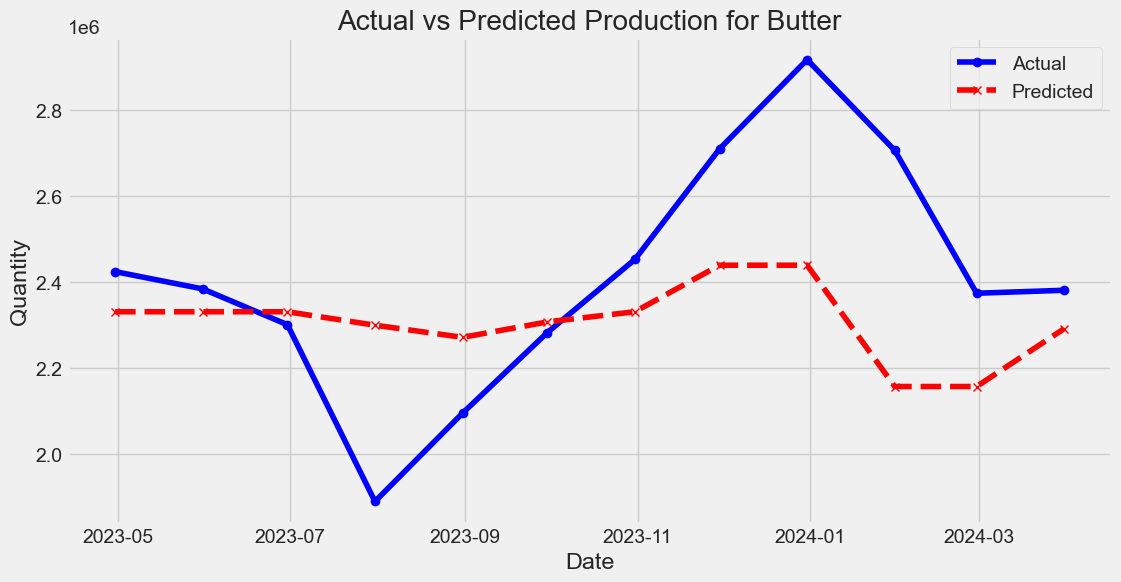

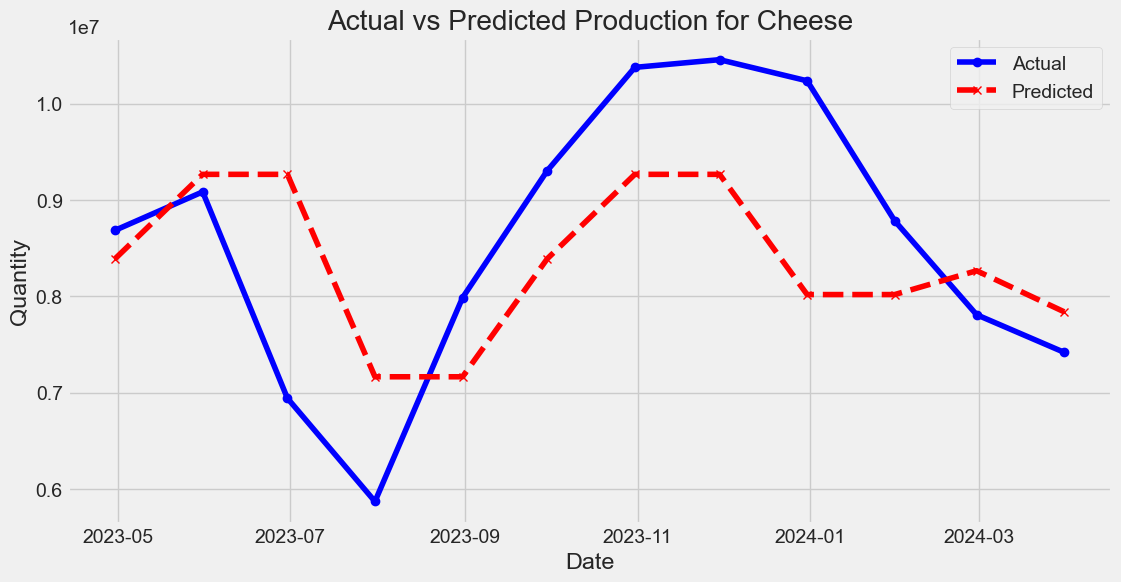

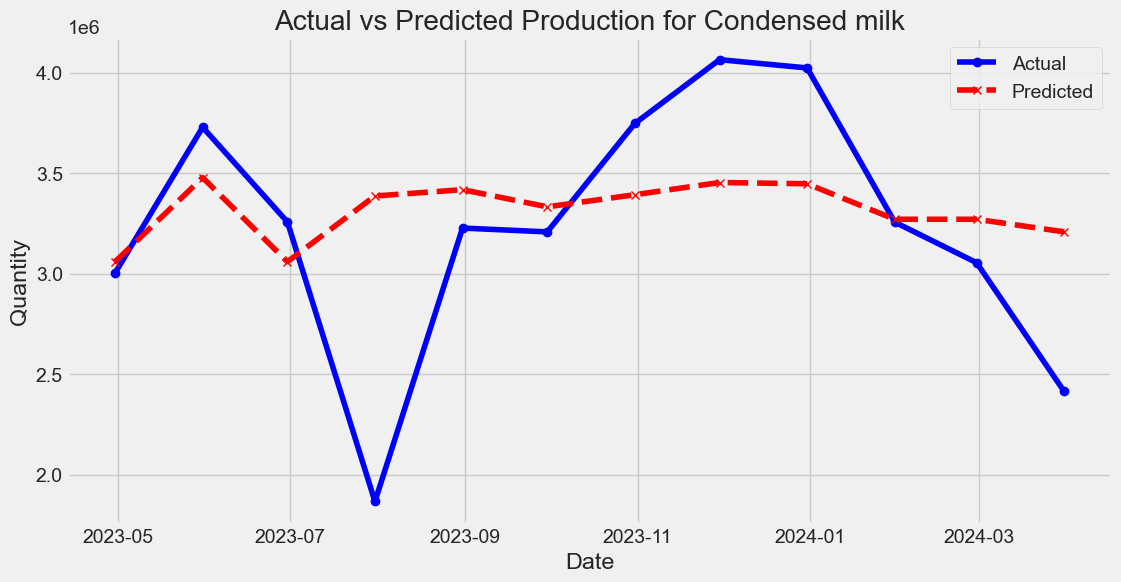

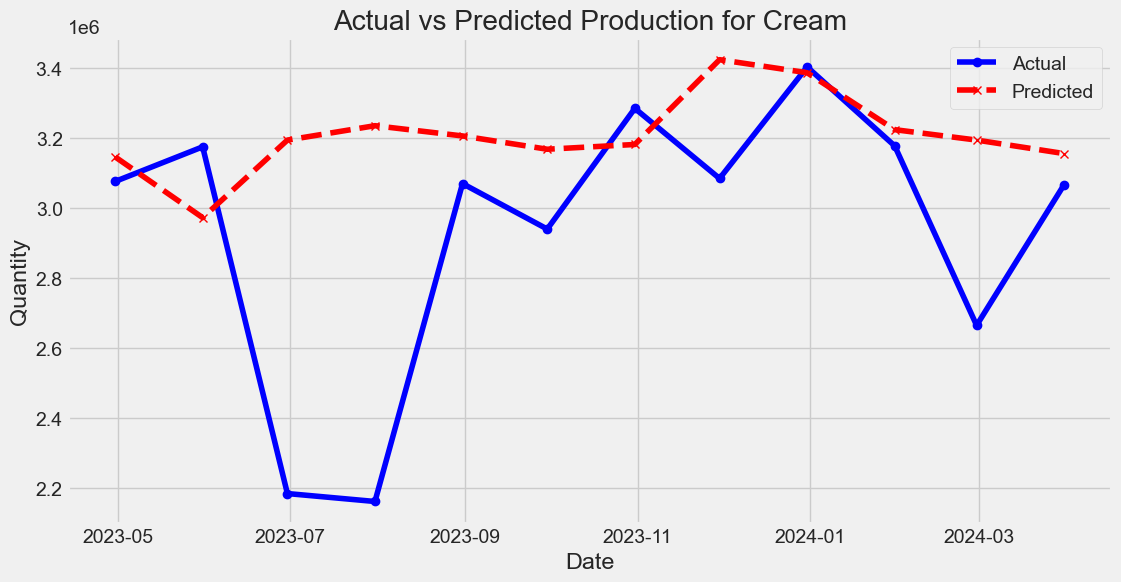

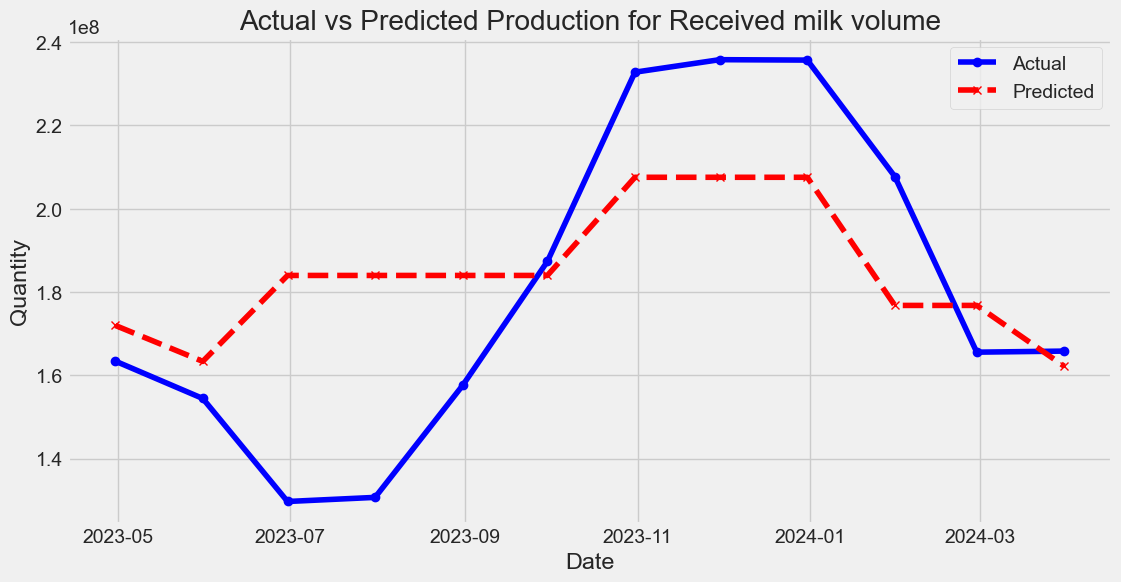

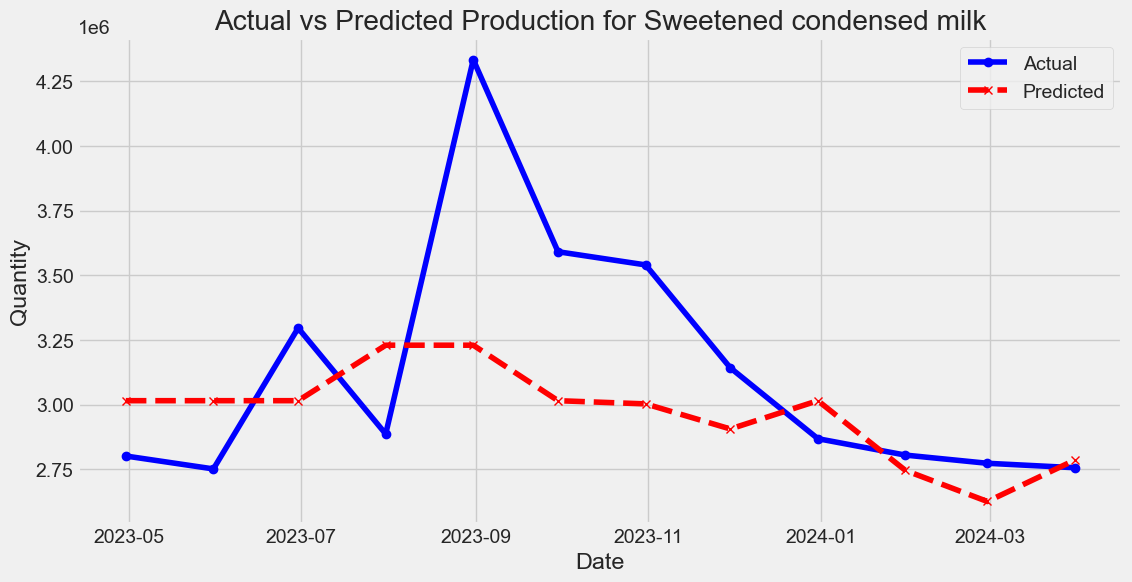

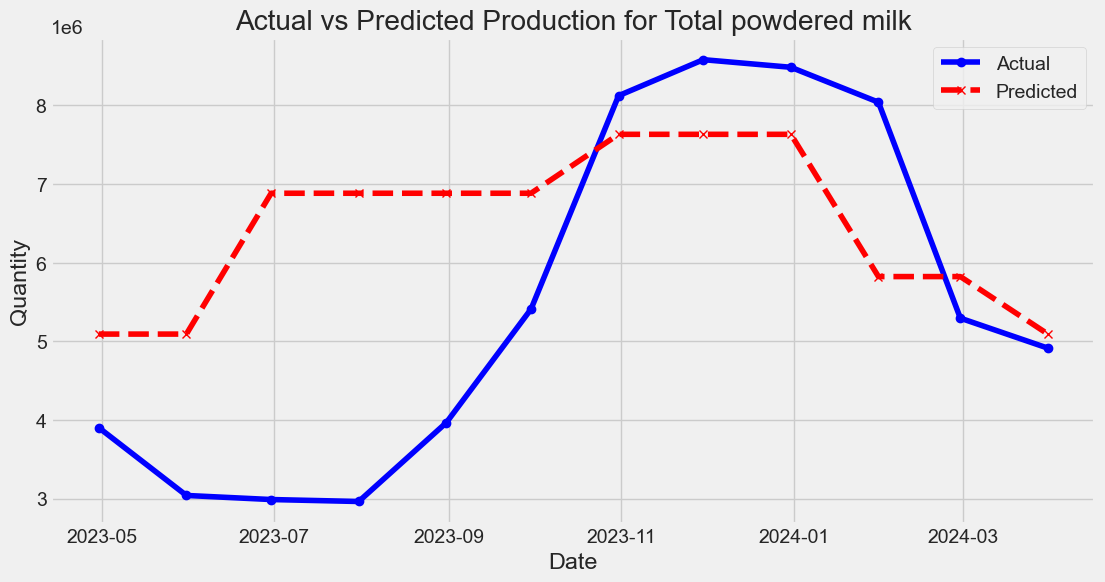

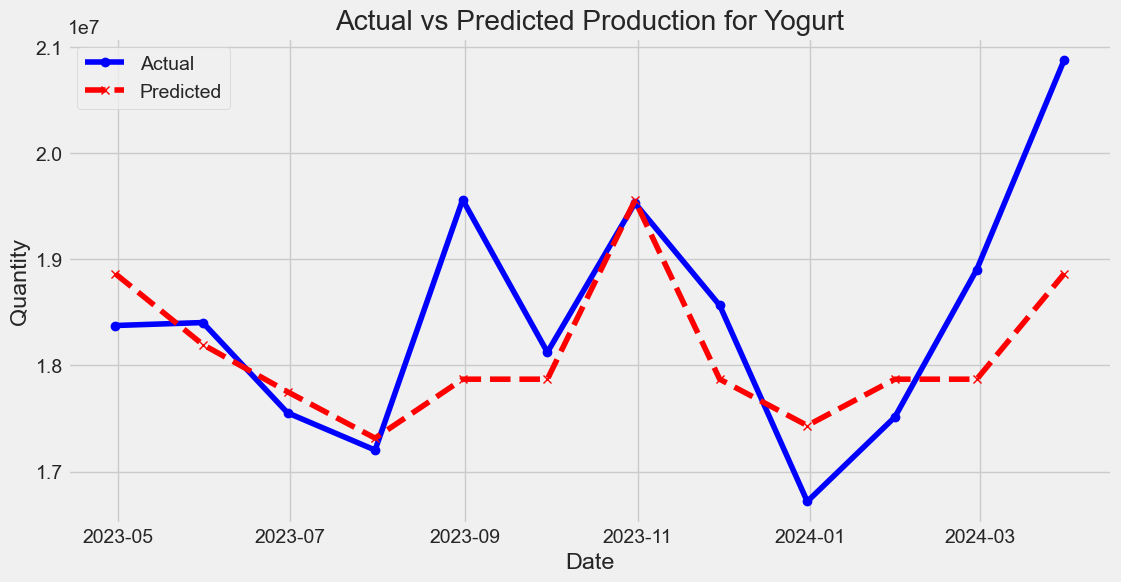

In [303]:
# Example for plotting predicted vs. actual values for a specific product
final_comparison = {}
for product in train_test_data:
    X_test = train_test_data[product]['X_test']
    y_test = train_test_data[product]['y_test']
    y_pred = models[product].predict(X_test)

    data = {'Actual': y_test, 
            'Predicted': y_pred,
            'Accuracy': (1 - (abs(y_test - y_pred)/y_test))*100}
    final_comparison[product] = pd.DataFrame(data)

    # Plotting the results
    plt.figure(figsize=(12, 6))  # Adjust size as necessary
    plt.plot(y_test.index, y_test, label='Actual', marker='o', linestyle='-', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted', marker='x', linestyle='--', color='red')
    plt.title(f'Actual vs Predicted Production for {product}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

In [265]:
final_comparison

{'Butter':              Actual   Predicted   Accuracy
 year_month                                
 2023-04-30  2424143  2332665.50  96.226398
 2023-05-31  2383922  2332665.50  97.849909
 2023-06-30  2300741  2332665.50  98.612425
 2023-07-31  1889421  2304154.00  78.049731
 2023-08-31  2094833  2262489.50  91.996665
 2023-09-30  2282202  2308995.00  98.826002
 2023-10-31  2452396  2332665.50  95.117815
 2023-11-30  2709620  2481449.75  91.579253
 2023-12-31  2917140  2481449.75  85.064472
 2024-01-31  2706265  2139359.25  79.052098
 2024-02-29  2373820  2139359.25  90.123061
 2024-03-31  2380774  2274047.25  95.517141,
 'Cheese':               Actual  Predicted   Accuracy
 year_month                                
 2023-04-30   8685289  8463773.0  97.449526
 2023-05-31   9084527  9563964.0  94.722488
 2023-06-30   6941690  9339360.0  65.459852
 2023-07-31   5869128  6825245.0  83.709386
 2023-08-31   7984855  6827940.5   85.51114
 2023-09-30   9304558  8359173.0   89.83955
 2023-10-31

In [266]:
accuracy_list = {}
for product in final_comparison:
    accuracy = round(np.mean(final_comparison[product]['Accuracy']), 2)
    accuracy_list[product] = accuracy

accuracy_list

{'Butter': 91.5,
 'Cheese': 88.29,
 'Condensed milk': 84.55,
 'Cream': 86.04,
 'Received milk volume': 86.67,
 'Sweetened condensed milk': 89.73,
 'Total powdered milk': 56.65,
 'Yogurt': 96.38,
 'Total Liquid Milk': 85.26}

#### *Entire Dataset Approach*

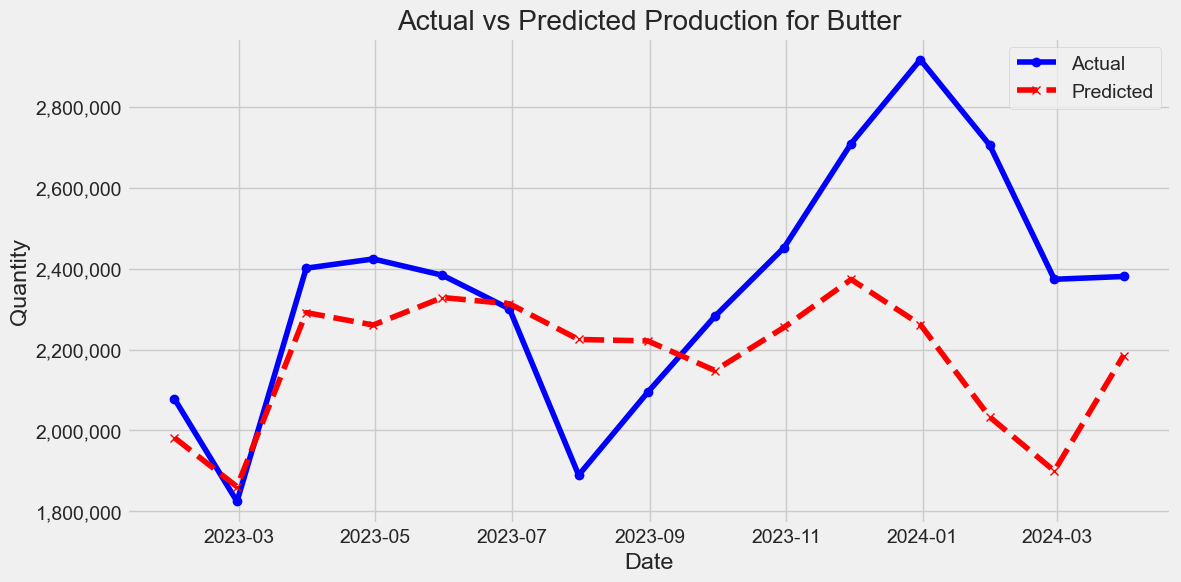

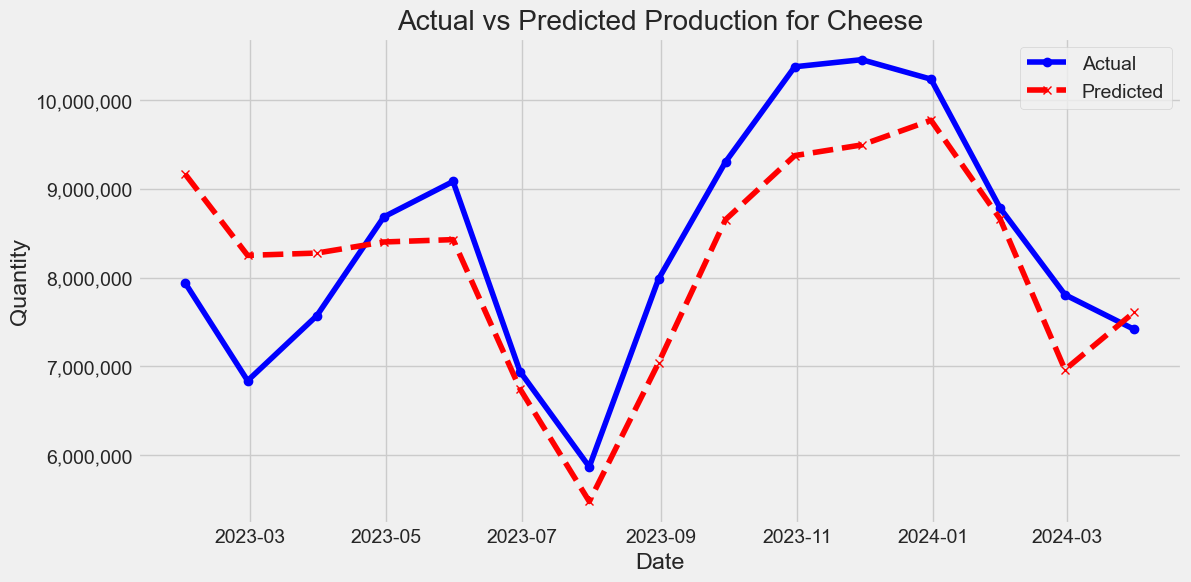

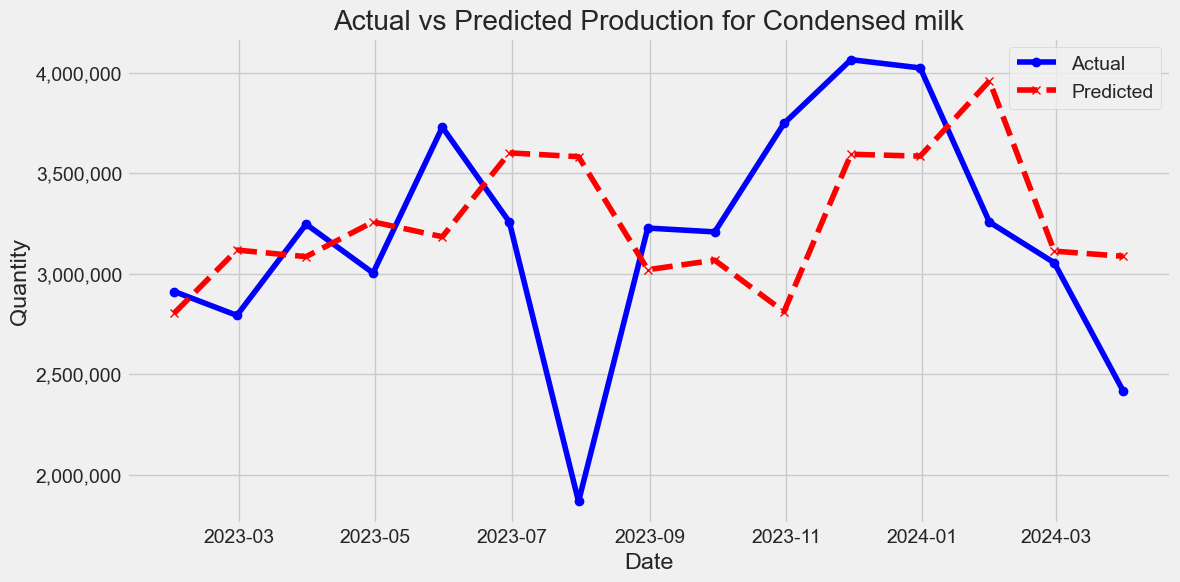

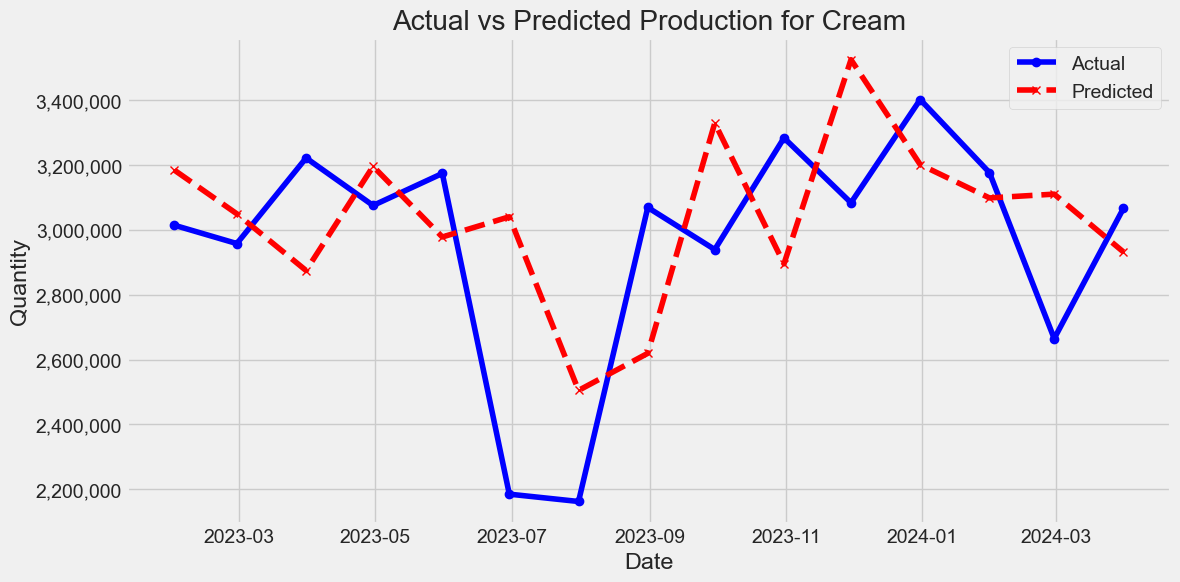

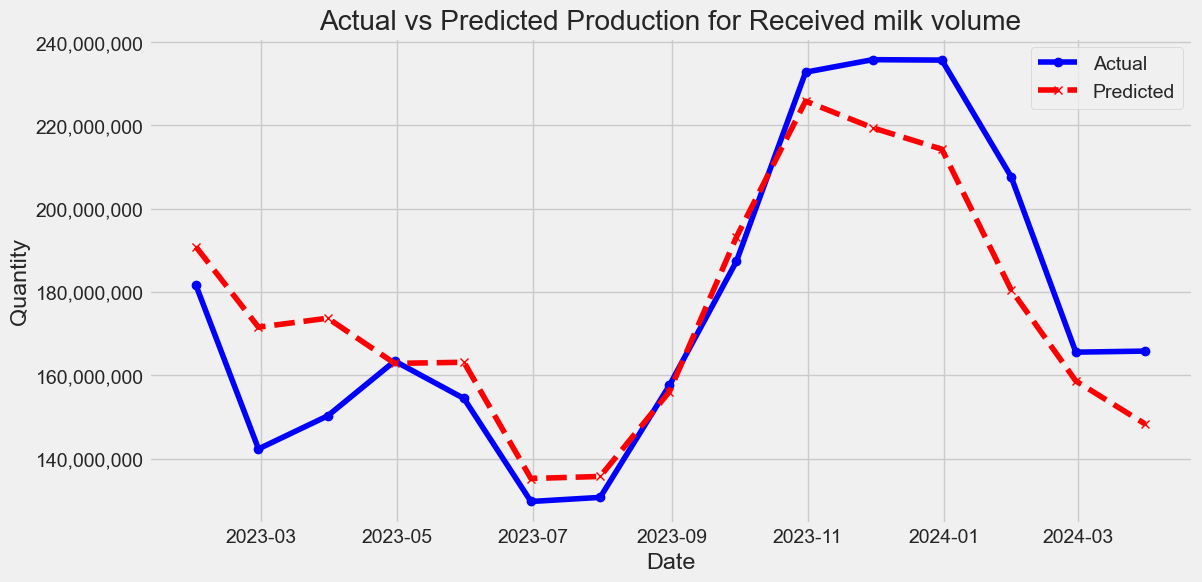

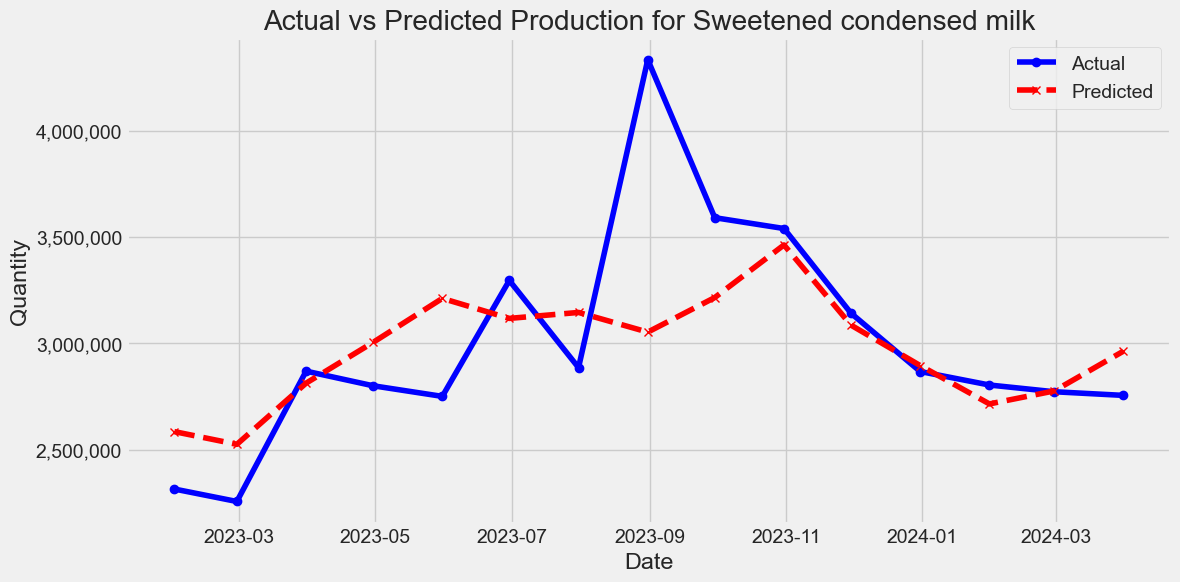

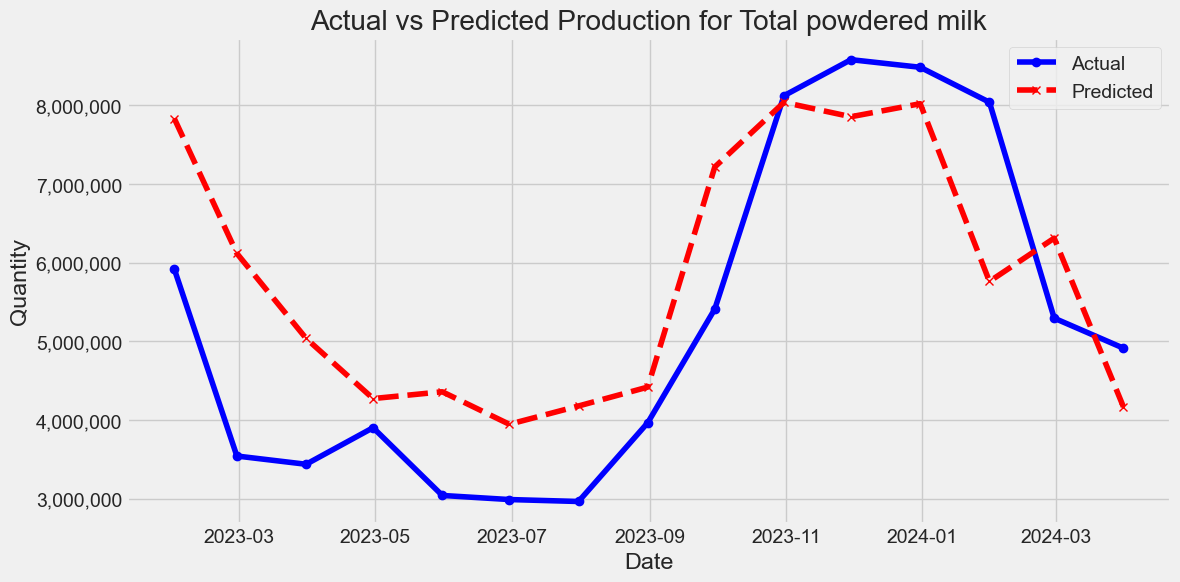

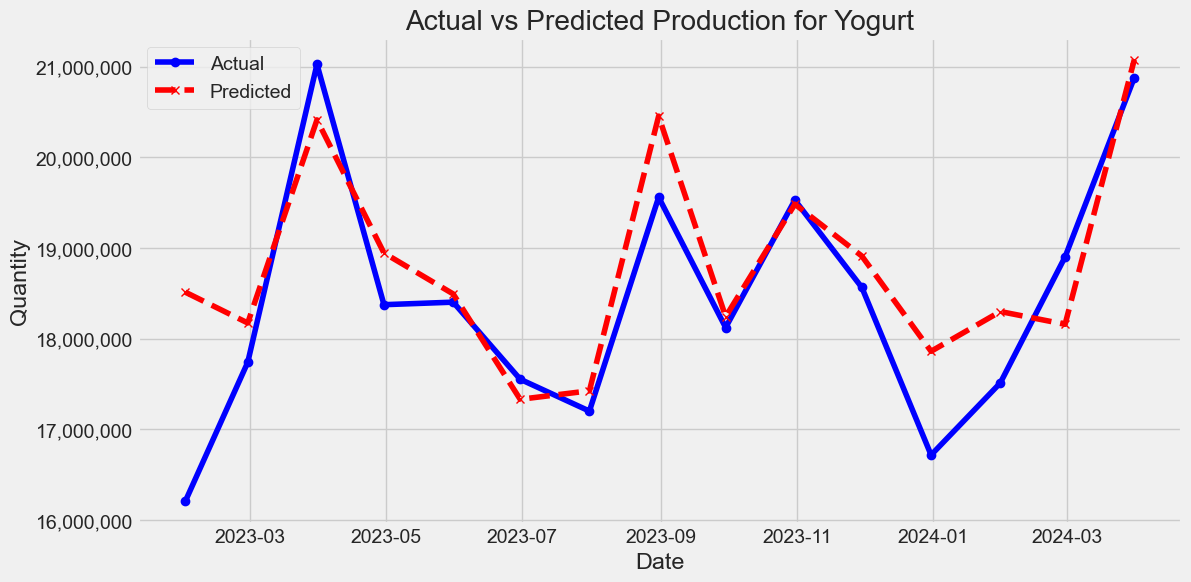

In [426]:
# Dictionary to store training and testing data for each product
train_test_data_final = {}
# Dictionary to store the models for each product
models = {}

# Dictionary to store evaluation metrics for each product
evaluation_metrics = {}
evaluation_results = {}

# Start training from the initial size and move the window
rmse_scores = []  # List to store the mean squared error for each prediction step

# Loop through each product to apply the rolling window approach
for product in product_data_with_lags:
    product_df = product_data_with_lags[product]
    
    # Define features (X) and target (y)
    X = product_df.drop('Quantity', axis=1)
    y = product_df['Quantity']

    
    
    X_train = X.iloc[:240]
    y_train = y.iloc[:240]
    X_test = X.iloc[240:]
    y_test = y.iloc[240:]

    # Store training and testing sets in another dictionary
    train_test_data_final[product] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
#____________________________________________________________________________________   
    # Train the model
    model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.01, max_depth=5, objective='reg:squarederror')
    '''
        n_estimators: Number of boosting rounds. This is how many times the model goes through the cycle of learning errors from the previous predictions and updating to make better predictions.
        learning_rate: Also known as the step size, this determines how quickly the model adjusts the weights on the features to minimize the loss.
        max_depth: This controls the maximum depth of each tree. Deeper trees can learn more specific patterns but might lead to overfitting.
        objective: Set to 'reg:squarederror' to specify that we are dealing with a regression problem and we want to minimize the squared error of predictions.
    '''
    model.fit(X_train, y_train)

    # Store the model in the dictionary
    models[product] = model

#___________________________________________________________________________________
    # Predict on the test set
    y_pred = model.predict(X_test)

    

    # Plotting the results
    fig = plt.figure(figsize=(12, 6))  # Adjust size as necessary
    ax = fig.gca()  # Get current axis
    plt.plot(y_test.index, y_test, label='Actual', marker='o', linestyle='-', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted', marker='x', linestyle='--', color='red')
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.title(f'Actual vs Predicted Production for {product}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()




In [311]:
evaluation_metrics = {}
final_comparison = {}
for product in train_test_data_final:
    X_test = train_test_data_final[product]['X_test']
    y_test = train_test_data_final[product]['y_test']
    y_pred = models[product].predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    evaluation_metrics[product] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

    data = {'Actual': y_test, 
            'Predicted': y_pred,
            'Accuracy': (1 - (abs(y_test - y_pred)/y_test))*100}
    final_comparison[product] = pd.DataFrame(data)

In [312]:
accuracy_list = {}
for product in final_comparison:
    accuracy = round(np.mean(final_comparison[product]['Accuracy']), 2)
    accuracy_list[product] = accuracy

print(evaluation_metrics)
accuracy_list


{'Butter': {'MSE': 99724524574.4375, 'RMSE': 315791.9007423045, 'MAE': 240047.55, 'MAPE': 0.09761973533044108}, 'Cheese': {'MSE': 594340431349.4833, 'RMSE': 770934.777623557, 'MAE': 669914.6333333333, 'MAPE': 0.08156363605158008}, 'Condensed milk': {'MSE': 391357003895.975, 'RMSE': 625585.3290287225, 'MAE': 471961.9666666667, 'MAPE': 0.17035682761146317}, 'Cream': {'MSE': 135094684182.30833, 'RMSE': 367552.28768477053, 'MAE': 310384.26666666666, 'MAPE': 0.11217436725450519}, 'Received milk volume': {'MSE': 235088563424791.6, 'RMSE': 15332598.065063585, 'MAE': 12361091.2, 'MAPE': 0.07081866731504753}, 'Sweetened condensed milk': {'MSE': 156143654435.27084, 'RMSE': 395150.1669432405, 'MAE': 254294.31666666668, 'MAPE': 0.07981404090748036}, 'Total powdered milk': {'MSE': 1876075353527.454, 'RMSE': 1369699.0010682836, 'MAE': 1168628.3833333333, 'MAPE': 0.2667439327711178}, 'Yogurt': {'MSE': 651722603198.6, 'RMSE': 807293.3811190329, 'MAE': 582366.8666666667, 'MAPE': 0.03286176071664273}}


{'Butter': 90.24,
 'Cheese': 91.84,
 'Condensed milk': 82.96,
 'Cream': 88.78,
 'Received milk volume': 92.92,
 'Sweetened condensed milk': 92.02,
 'Total powdered milk': 73.33,
 'Yogurt': 96.71}

#### *Expanding Window Approach*


Expanding Window for Butter:
Average MSE for Butter: 241113.705
{'Butter': {'MSE': 102918343425.82422, 'RMSE': 320808.8892562427, 'MAE': 235989.15625, 'MAPE': 0.0967977176679492}}


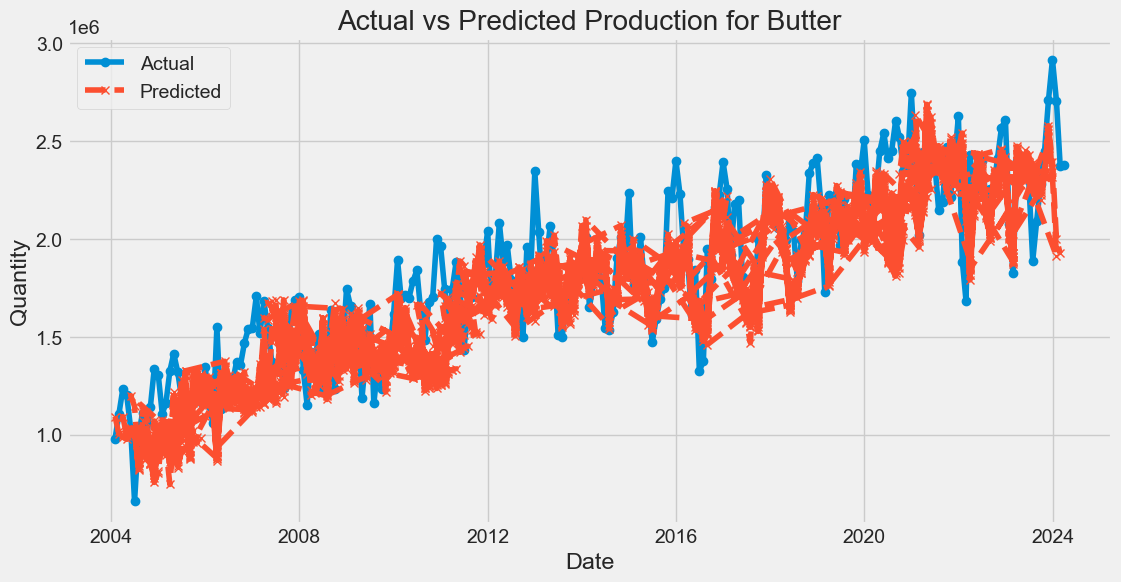


Expanding Window for Cheese:
Average MSE for Cheese: 736546.326
{'Butter': {'MSE': 102918343425.82422, 'RMSE': 320808.8892562427, 'MAE': 235989.15625, 'MAPE': 0.0967977176679492}, 'Cheese': {'MSE': 371777142851.7083, 'RMSE': 609735.3055643968, 'MAE': 508456.0, 'MAPE': 0.06284690960535501}}


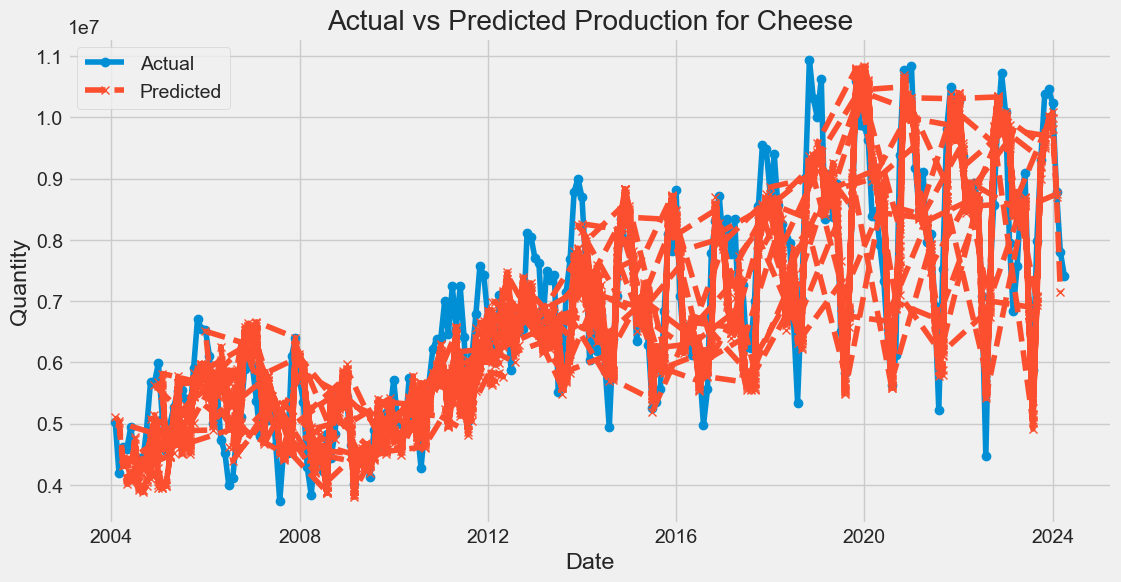


Expanding Window for Condensed milk:
Average MSE for Condensed milk: 705884.380
{'Butter': {'MSE': 102918343425.82422, 'RMSE': 320808.8892562427, 'MAE': 235989.15625, 'MAPE': 0.0967977176679492}, 'Cheese': {'MSE': 371777142851.7083, 'RMSE': 609735.3055643968, 'MAE': 508456.0, 'MAPE': 0.06284690960535501}, 'Condensed milk': {'MSE': 475049748657.1042, 'RMSE': 689238.5281287634, 'MAE': 527608.9166666666, 'MAPE': 0.18567321812526405}}


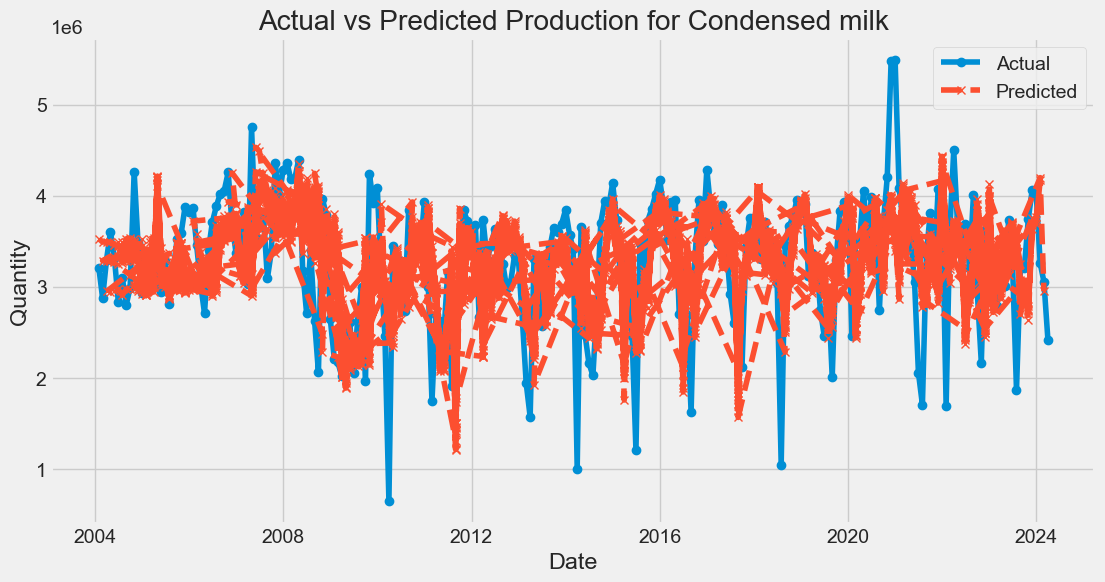


Expanding Window for Cream:
Average MSE for Cream: 450781.668
{'Butter': {'MSE': 102918343425.82422, 'RMSE': 320808.8892562427, 'MAE': 235989.15625, 'MAPE': 0.0967977176679492}, 'Cheese': {'MSE': 371777142851.7083, 'RMSE': 609735.3055643968, 'MAE': 508456.0, 'MAPE': 0.06284690960535501}, 'Condensed milk': {'MSE': 475049748657.1042, 'RMSE': 689238.5281287634, 'MAE': 527608.9166666666, 'MAPE': 0.18567321812526405}, 'Cream': {'MSE': 150120748279.83853, 'RMSE': 387454.18862084654, 'MAE': 305615.9791666667, 'MAPE': 0.11400054131430415}}


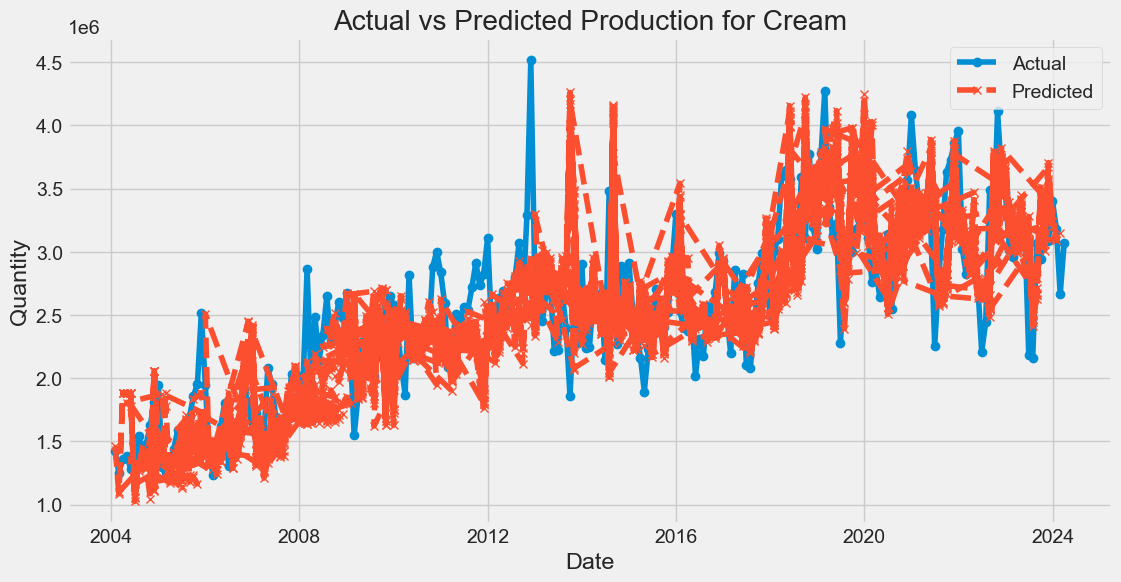


Expanding Window for Received milk volume:
Average MSE for Received milk volume: 11271256.581
{'Butter': {'MSE': 102918343425.82422, 'RMSE': 320808.8892562427, 'MAE': 235989.15625, 'MAPE': 0.0967977176679492}, 'Cheese': {'MSE': 371777142851.7083, 'RMSE': 609735.3055643968, 'MAE': 508456.0, 'MAPE': 0.06284690960535501}, 'Condensed milk': {'MSE': 475049748657.1042, 'RMSE': 689238.5281287634, 'MAE': 527608.9166666666, 'MAPE': 0.18567321812526405}, 'Cream': {'MSE': 150120748279.83853, 'RMSE': 387454.18862084654, 'MAE': 305615.9791666667, 'MAPE': 0.11400054131430415}, 'Received milk volume': {'MSE': 157507016875888.1, 'RMSE': 12550179.953924488, 'MAE': 9141732.583333334, 'MAPE': 0.05062336893496556}}


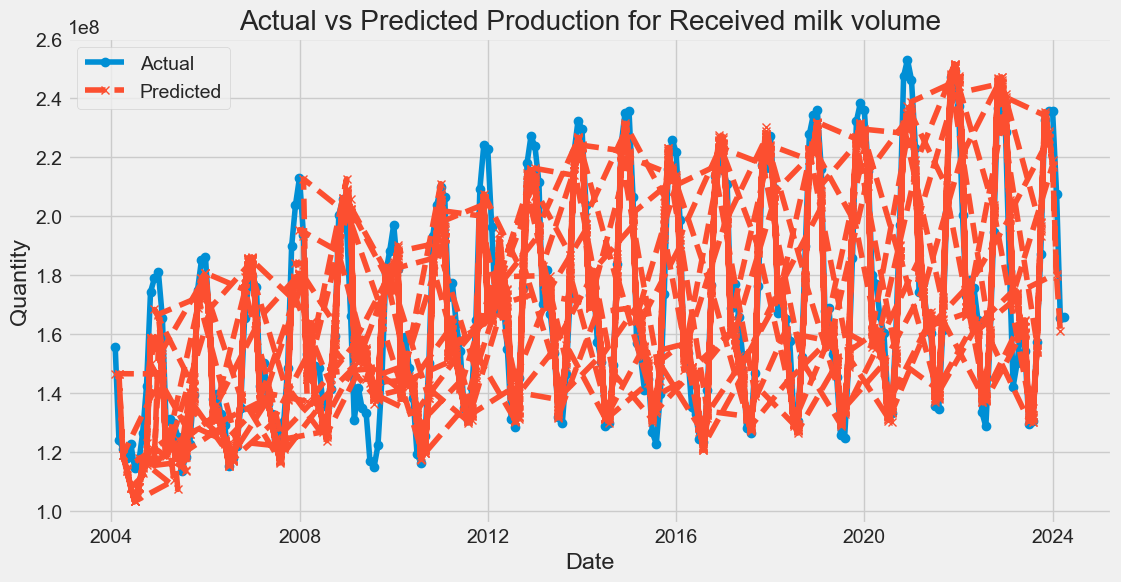


Expanding Window for Sweetened condensed milk:
Average MSE for Sweetened condensed milk: 365341.255
{'Butter': {'MSE': 102918343425.82422, 'RMSE': 320808.8892562427, 'MAE': 235989.15625, 'MAPE': 0.0967977176679492}, 'Cheese': {'MSE': 371777142851.7083, 'RMSE': 609735.3055643968, 'MAE': 508456.0, 'MAPE': 0.06284690960535501}, 'Condensed milk': {'MSE': 475049748657.1042, 'RMSE': 689238.5281287634, 'MAE': 527608.9166666666, 'MAPE': 0.18567321812526405}, 'Cream': {'MSE': 150120748279.83853, 'RMSE': 387454.18862084654, 'MAE': 305615.9791666667, 'MAPE': 0.11400054131430415}, 'Received milk volume': {'MSE': 157507016875888.1, 'RMSE': 12550179.953924488, 'MAE': 9141732.583333334, 'MAPE': 0.05062336893496556}, 'Sweetened condensed milk': {'MSE': 193772562027.39584, 'RMSE': 440196.0495363354, 'MAE': 266545.5833333333, 'MAPE': 0.0793504792935077}}


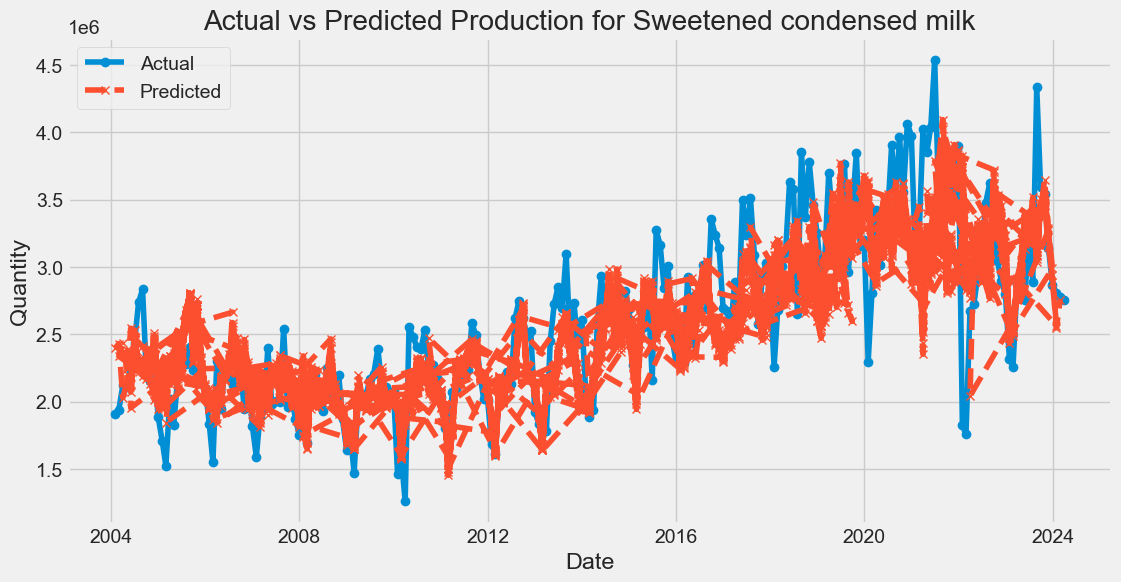


Expanding Window for Total powdered milk:
Average MSE for Total powdered milk: 1294476.103
{'Butter': {'MSE': 102918343425.82422, 'RMSE': 320808.8892562427, 'MAE': 235989.15625, 'MAPE': 0.0967977176679492}, 'Cheese': {'MSE': 371777142851.7083, 'RMSE': 609735.3055643968, 'MAE': 508456.0, 'MAPE': 0.06284690960535501}, 'Condensed milk': {'MSE': 475049748657.1042, 'RMSE': 689238.5281287634, 'MAE': 527608.9166666666, 'MAPE': 0.18567321812526405}, 'Cream': {'MSE': 150120748279.83853, 'RMSE': 387454.18862084654, 'MAE': 305615.9791666667, 'MAPE': 0.11400054131430415}, 'Received milk volume': {'MSE': 157507016875888.1, 'RMSE': 12550179.953924488, 'MAE': 9141732.583333334, 'MAPE': 0.05062336893496556}, 'Sweetened condensed milk': {'MSE': 193772562027.39584, 'RMSE': 440196.0495363354, 'MAE': 266545.5833333333, 'MAPE': 0.0793504792935077}, 'Total powdered milk': {'MSE': 1028504052000.5104, 'RMSE': 1014151.8880328087, 'MAE': 778648.875, 'MAPE': 0.17279461855385514}}


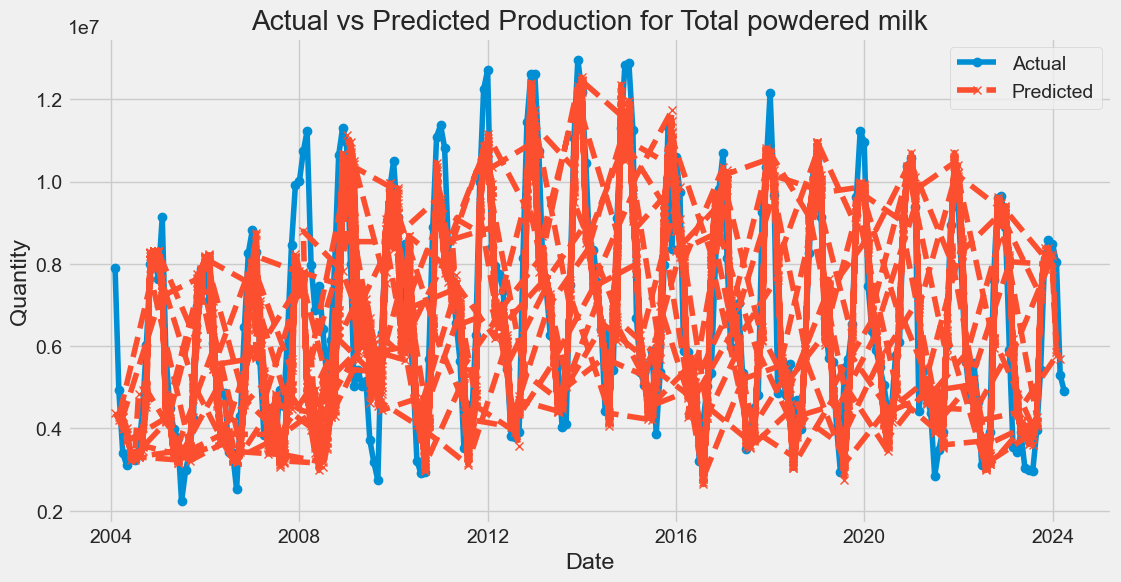


Expanding Window for Yogurt:
Average MSE for Yogurt: 1657085.506
{'Butter': {'MSE': 102918343425.82422, 'RMSE': 320808.8892562427, 'MAE': 235989.15625, 'MAPE': 0.0967977176679492}, 'Cheese': {'MSE': 371777142851.7083, 'RMSE': 609735.3055643968, 'MAE': 508456.0, 'MAPE': 0.06284690960535501}, 'Condensed milk': {'MSE': 475049748657.1042, 'RMSE': 689238.5281287634, 'MAE': 527608.9166666666, 'MAPE': 0.18567321812526405}, 'Cream': {'MSE': 150120748279.83853, 'RMSE': 387454.18862084654, 'MAE': 305615.9791666667, 'MAPE': 0.11400054131430415}, 'Received milk volume': {'MSE': 157507016875888.1, 'RMSE': 12550179.953924488, 'MAE': 9141732.583333334, 'MAPE': 0.05062336893496556}, 'Sweetened condensed milk': {'MSE': 193772562027.39584, 'RMSE': 440196.0495363354, 'MAE': 266545.5833333333, 'MAPE': 0.0793504792935077}, 'Total powdered milk': {'MSE': 1028504052000.5104, 'RMSE': 1014151.8880328087, 'MAE': 778648.875, 'MAPE': 0.17279461855385514}, 'Yogurt': {'MSE': 401971674822.25, 'RMSE': 634012.3617266

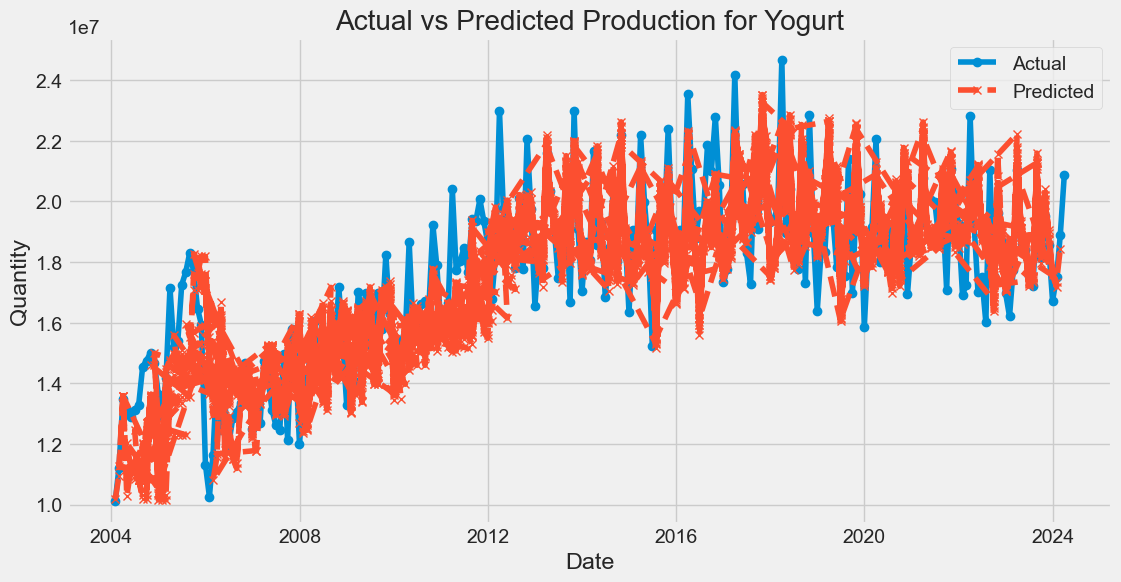


Expanding Window for Total Liquid Milk:
Average MSE for Total Liquid Milk: 3683808.549
{'Butter': {'MSE': 102918343425.82422, 'RMSE': 320808.8892562427, 'MAE': 235989.15625, 'MAPE': 0.0967977176679492}, 'Cheese': {'MSE': 371777142851.7083, 'RMSE': 609735.3055643968, 'MAE': 508456.0, 'MAPE': 0.06284690960535501}, 'Condensed milk': {'MSE': 475049748657.1042, 'RMSE': 689238.5281287634, 'MAE': 527608.9166666666, 'MAPE': 0.18567321812526405}, 'Cream': {'MSE': 150120748279.83853, 'RMSE': 387454.18862084654, 'MAE': 305615.9791666667, 'MAPE': 0.11400054131430415}, 'Received milk volume': {'MSE': 157507016875888.1, 'RMSE': 12550179.953924488, 'MAE': 9141732.583333334, 'MAPE': 0.05062336893496556}, 'Sweetened condensed milk': {'MSE': 193772562027.39584, 'RMSE': 440196.0495363354, 'MAE': 266545.5833333333, 'MAPE': 0.0793504792935077}, 'Total powdered milk': {'MSE': 1028504052000.5104, 'RMSE': 1014151.8880328087, 'MAE': 778648.875, 'MAPE': 0.17279461855385514}, 'Yogurt': {'MSE': 401971674822.25, 

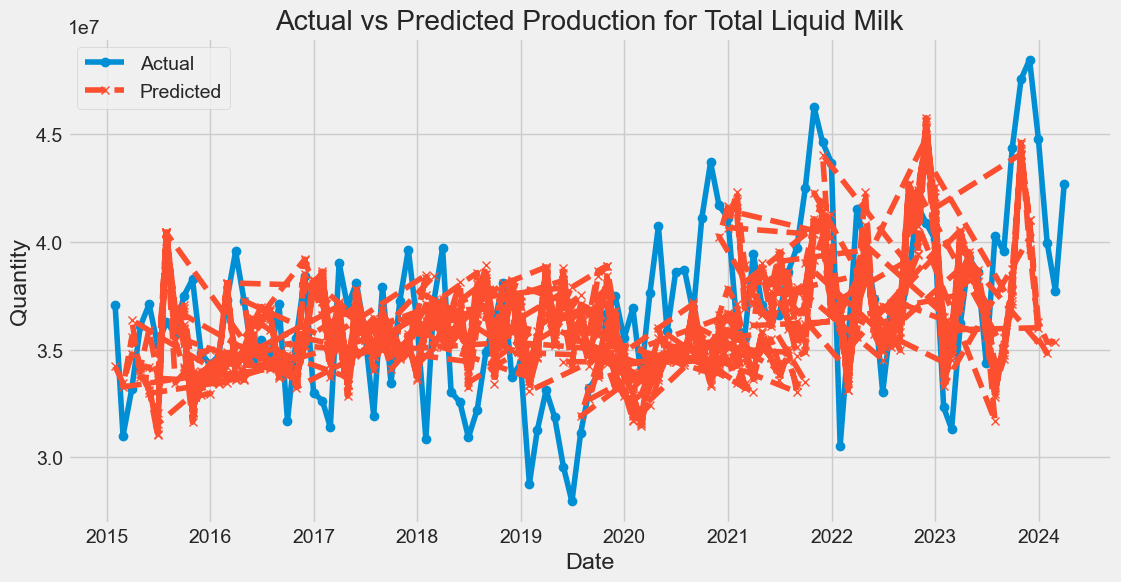

In [212]:
'''An expanding window approach for time series forecasting involves using all available past data up to a certain point to train the model, and then testing it on the subsequent data. 
This method is particularly useful for time series where you continuously accumulate more data that can be used to improve the model's training.'''
# Initialize the dictionary to store the evaluation results
evaluation_results_expanding = {}
evaluation_metrics_expanding = {}

# Dictionary to store training and testing data for each product
train_test_data2 = {}
# Dictionary to store the models for each product
models = {}

# Parameters for the expanding window
initial_train_size = 12  # The initial amount of data for training
horizon = 12             # The number of months to predict in each step
gap = 0                 # The gap between the training set and test set

# Loop through each product to apply the expanding window approach
for product in product_data_with_lags:
    product_df = product_data_with_lags[product]
    
    # Define features (X) and target (y)
    X = product_df.drop('Quantity', axis=1)
    y = product_df['Quantity']

    # Determine the total number of data points
    total_size = len(product_df)
    
    # Start training from the initial size and move the window
    rmse_scores = []  # List to store the mean squared error for each prediction step

    predictions = []
    test_dates = []

    # For storing the model for the last train-test split
    final_model = None
    
    # Print out information for visualization
    print(f"\nExpanding Window for {product}:")
    
    for i in range(initial_train_size, total_size - horizon):
        X_train = X.iloc[:i]
        y_train = y.iloc[:i]
        X_test = X.iloc[i+gap:i+gap+horizon]
        y_test = y.iloc[i+gap:i+gap+horizon]

        # Store training and testing sets in another dictionary
        train_test_data2[product] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        }
        
        # Train the model
        model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, objective='reg:squarederror')
        '''
            n_estimators: Number of boosting rounds. This is how many times the model goes through the cycle of learning errors from the previous predictions and updating to make better predictions.
            learning_rate: Also known as the step size, this determines how quickly the model adjusts the weights on the features to minimize the loss.
            max_depth: This controls the maximum depth of each tree. Deeper trees can learn more specific patterns but might lead to overfitting.
            objective: Set to 'reg:squarederror' to specify that we are dealing with a regression problem and we want to minimize the squared error of predictions.
        '''
        model.fit(X_train, y_train)

        # Store the model in the dictionary
        models[product] = model
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        
        predictions.extend(y_pred)
        test_dates.extend(X_test.index)

        final_model = model  # Store the last model

        # Evaluate the model
        '''
        MSE (Mean Squared Error): Measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.
        RMSE (Root Mean Squared Error): The square root of MSE and a more interpretable measure as it's in the same units as the response variable. It indicates how close the observed data points are to the model’s predicted values.
        '''
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        
        # Store the metrics in the dictionary
        evaluation_metrics_expanding[product] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

        # Output the details of the split
        #print(f"Train range: 0 to {i-1}, Test range: {i+gap} to {i+gap+horizon-1}")
        #print(f"Test MSE: {mse:.3f}")

    # Store the average MSE for this product
    evaluation_results_expanding[product] = np.mean(rmse_scores)
    print(f"Average MSE for {product}: {evaluation_results_expanding[product]:.3f}")
    print(evaluation_metrics_expanding)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(y.index[initial_train_size:], y.iloc[initial_train_size:], label='Actual', marker='o')
    #plt.plot(test_dates, predictions, label='Predicted', marker='x', linestyle='--')
    plt.title(f'Actual vs Predicted Production for {product}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

In [204]:
print(evaluation_metrics_expanding)
print(evaluation_metrics_rolling)

{'Butter': {'MSE': 229714111225.0, 'RMSE': 479285.0, 'MAE': 479285.0, 'MAPE': 0.20190452519567617}, 'Cheese': {'MSE': 327976699556.25, 'RMSE': 572692.5, 'MAE': 572692.5, 'MAPE': 0.07334020002274383}, 'Condensed milk': {'MSE': 19225902306.25, 'RMSE': 138657.5, 'MAE': 138657.5, 'MAPE': 0.04540260088966602}, 'Cream': {'MSE': 146168964720.25, 'RMSE': 382320.5, 'MAE': 382320.5, 'MAPE': 0.14346098036795038}, 'Received milk volume': {'MSE': 21665133594724.0, 'RMSE': 4654582.0, 'MAE': 4654582.0, 'MAPE': 0.028116264034401692}, 'Sweetened condensed milk': {'MSE': 1721523826.5625, 'RMSE': 41491.25, 'MAE': 41491.25, 'MAPE': 0.014962914799063377}, 'Total powdered milk': {'MSE': 206410296976.0, 'RMSE': 454324.0, 'MAE': 454324.0, 'MAPE': 0.08580666850496908}, 'Yogurt': {'MSE': 155168239396.0, 'RMSE': 393914.0, 'MAE': 393914.0, 'MAPE': 0.02084036981638694}, 'Total Liquid Milk': {'MSE': 11297692329616.0, 'RMSE': 3361204.0, 'MAE': 3361204.0, 'MAPE': 0.08906062718405215}}
{'Butter': {'MSE': 104858163933.

### Prophet

In [323]:
total_df2.rename(columns={'year_month': 'ds', 'Quantity': 'y'}, inplace=True)
total_df2.drop(['Year', 'Month', 'Unity'], axis=1, inplace=True)
total_df2

ds                   Product          y
0     2002-01                    Butter     759525
1     2002-01                    Cheese    4475498
2     2002-01            Condensed milk    1921020
3     2002-01                     Cream    1799386
4     2002-01      Received milk volume  149680733
...       ...                       ...        ...
2131  2024-03                     Cream    3067012
2132  2024-03      Received milk volume  165805522
2133  2024-03  Sweetened condensed milk    2755774
2134  2024-03       Total powdered milk    4913198
2135  2024-03                    Yogurt   20878022

[2136 rows x 3 columns]

06:58:55 - cmdstanpy - INFO - Chain [1] start processing
06:58:55 - cmdstanpy - INFO - Chain [1] done processing


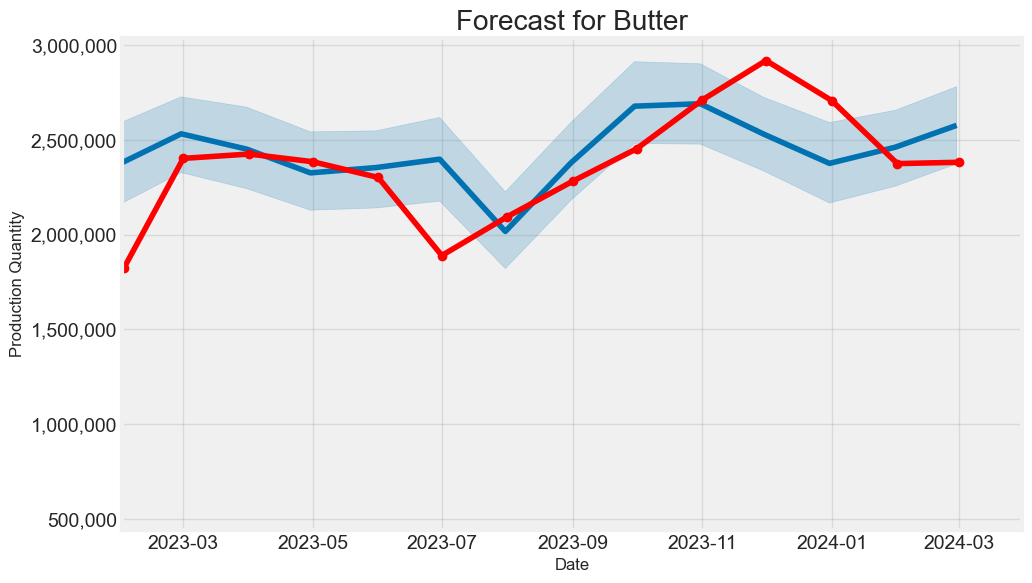

06:58:56 - cmdstanpy - INFO - Chain [1] start processing
06:58:56 - cmdstanpy - INFO - Chain [1] done processing


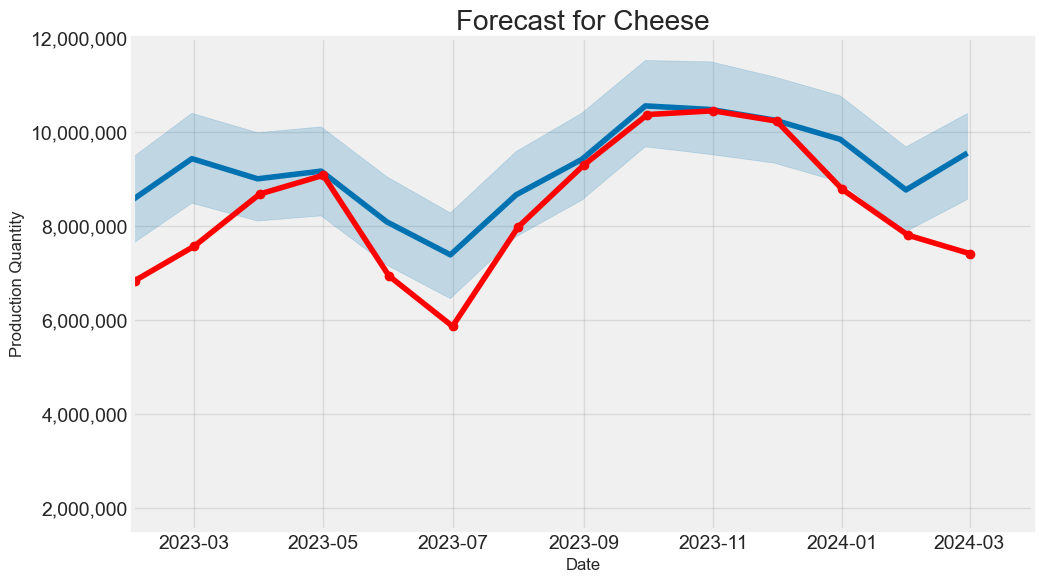

06:58:56 - cmdstanpy - INFO - Chain [1] start processing
06:58:56 - cmdstanpy - INFO - Chain [1] done processing


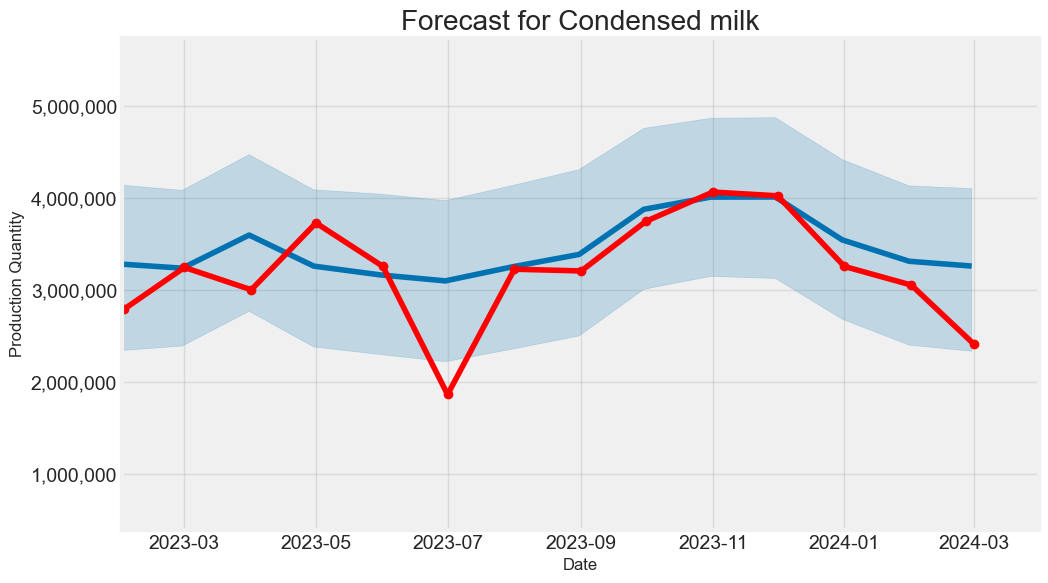

06:58:57 - cmdstanpy - INFO - Chain [1] start processing
06:58:57 - cmdstanpy - INFO - Chain [1] done processing


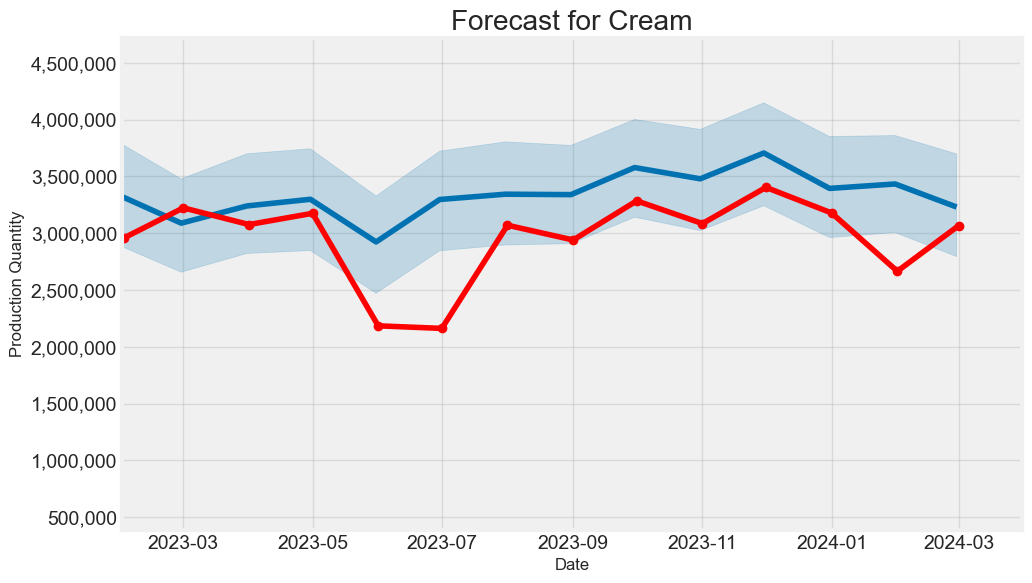

06:58:57 - cmdstanpy - INFO - Chain [1] start processing
06:58:57 - cmdstanpy - INFO - Chain [1] done processing


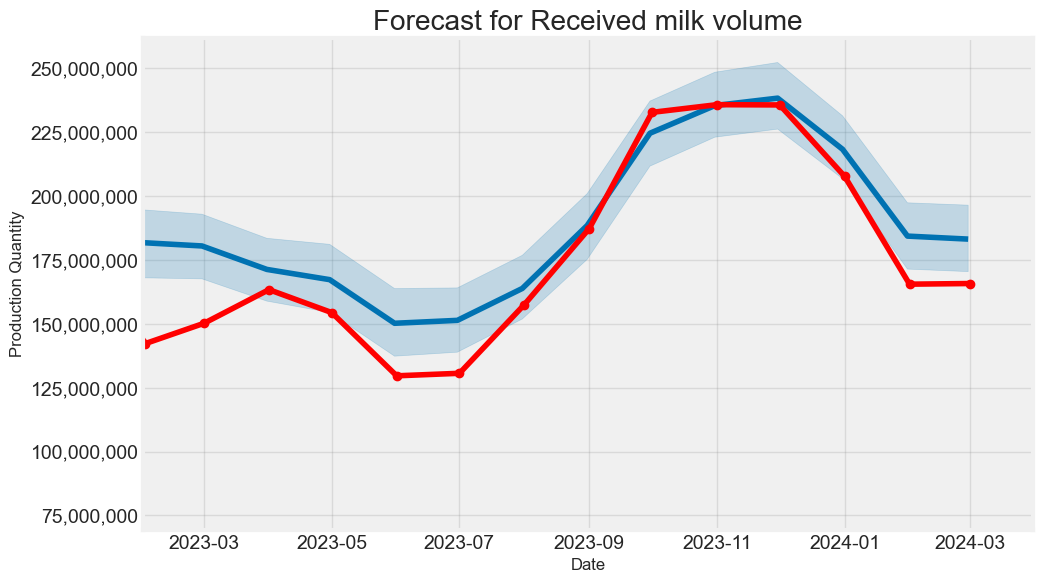

06:58:58 - cmdstanpy - INFO - Chain [1] start processing
06:58:58 - cmdstanpy - INFO - Chain [1] done processing


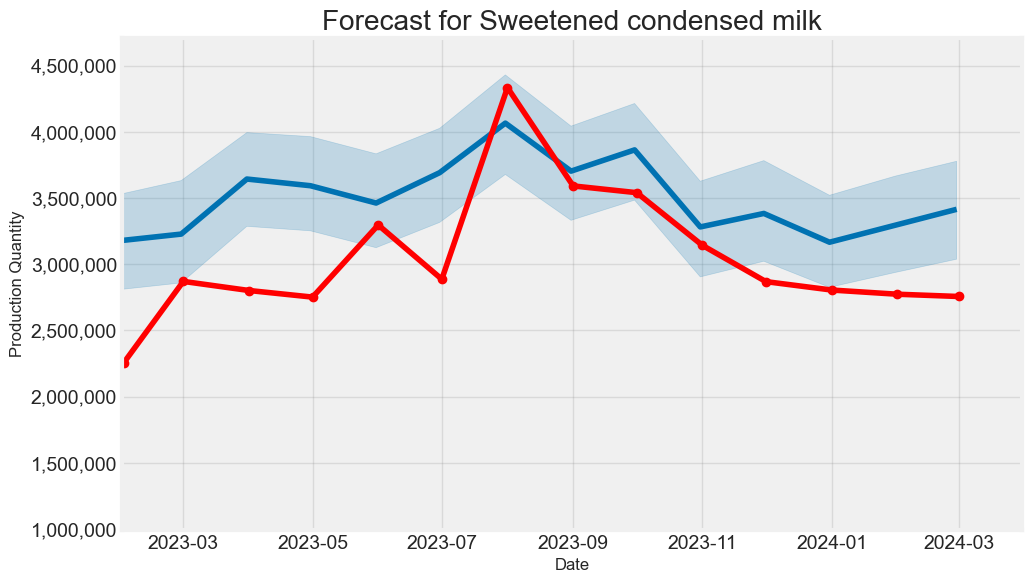

06:58:58 - cmdstanpy - INFO - Chain [1] start processing
06:58:58 - cmdstanpy - INFO - Chain [1] done processing


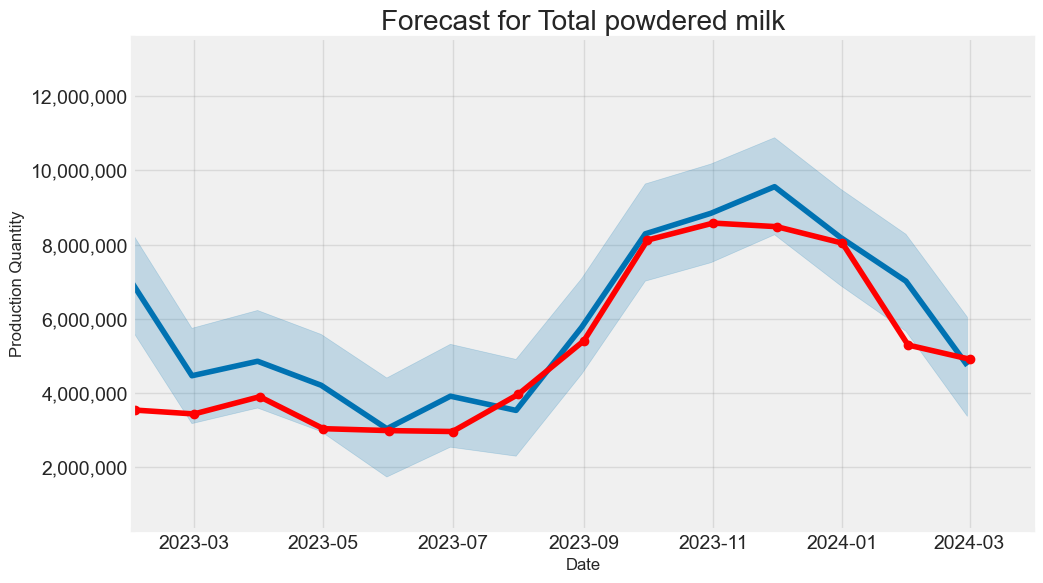

06:58:59 - cmdstanpy - INFO - Chain [1] start processing
06:58:59 - cmdstanpy - INFO - Chain [1] done processing


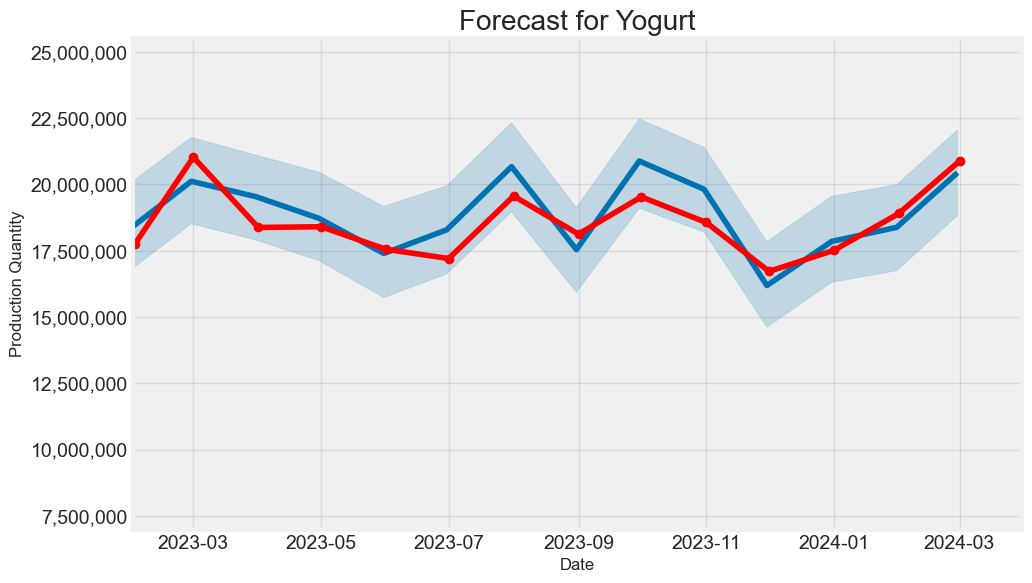

In [430]:
train_test_data_prophet = {}

# Dictionary to store each DataFrame 
product_data_prophet = {}

# Dictionary to store the models for each product
results_prophet = {}

for product in product_list:
    # Selecting data for the current product
    product_df = total_df2[total_df2['Product'] == product][['ds','y']]
    product_data_prophet[product] = product_df
    
    # Check if the 'ds' column is PeriodDtype and convert to timestamp
    if pd.api.types.is_period_dtype(product_df['ds']):
        product_df['ds'] = product_df['ds'].dt.to_timestamp()

    # Continue with the conversion to datetime
    product_df['ds'] = pd.to_datetime(product_df['ds'])

    X_train = product_df.iloc[:252]

    y_test = product_df.iloc[252:]

    # Store training and testing sets in another dictionary
    train_test_data_prophet[product] = {
        'X_train': X_train,
        'y_test': y_test
    }

    # Initialize the Prophet model
    model = Prophet()

    # Fit the model
    model.fit(X_train)

    
    # Create a future DataFrame for next 12 months
    future = model.make_future_dataframe(periods=15, freq='M')  # Monthly frequency

    # Predict future values
    forecast = model.predict(future)

    results_prophet[product] = forecast['yhat'].iloc[252:]

    # Plot the forecast
    fig = model.plot(forecast)
    ax = fig.gca()  # Get current axis
    ax.plot(product_df['ds'], product_df['y'], label='y test', marker='o', color='red')
    # Format the y-axis to show complete numbers
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xlim(pd.Timestamp('2023-01-31'), pd.Timestamp('2024-03-31'))  # Adjust to focus on a specific period
    plt.title(f'Forecast for {product}')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Production Quantity', fontsize=12)
    plt.show()

In [421]:
evaluation_metrics_prophet = {}
final_comparison_prophet = {}
for product in train_test_data_prophet:
    
    y_test = train_test_data_prophet[product]['y_test'].drop(['ds'], axis=1).reset_index()
    y_test = np.array(y_test['y'])

    y_pred = np.array(np.int64(results_prophet[product]))

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    evaluation_metrics[product] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

    data = {'Actual': y_test, 
            'Predicted': y_pred,
            'Accuracy': (1 - (abs(y_test - y_pred)/y_test))*100}
    final_comparison_prophet[product] = data

In [422]:
accuracy_list = {}
for product in final_comparison_prophet:
    accuracy = round(np.mean(final_comparison_prophet[product]['Accuracy']), 2)
    accuracy_list[product] = accuracy

print(evaluation_metrics)
accuracy_list

{'Butter': {'MSE': 68457745940.4, 'RMSE': 261644.3118823721, 'MAE': 200363.86666666667, 'MAPE': 0.0907036129863862}, 'Cheese': {'MSE': 1340509756340.6667, 'RMSE': 1157803.8505466576, 'MAE': 902244.9333333333, 'MAPE': 0.1221943104595784}, 'Condensed milk': {'MSE': 242276154971.0, 'RMSE': 492215.5574247933, 'MAE': 352878.6, 'MAPE': 0.1360011718526273}, 'Cream': {'MSE': 222768667504.2, 'RMSE': 471983.7576699012, 'MAE': 384287.8, 'MAPE': 0.14386010095001092}, 'Received milk volume': {'MSE': 376213940340623.8, 'RMSE': 19396235.210489273, 'MAE': 15467046.466666667, 'MAPE': 0.09884899974821502}, 'Sweetened condensed milk': {'MSE': 329362178134.2, 'RMSE': 573900.8434688, 'MAE': 505399.6666666667, 'MAPE': 0.18373520500131582}, 'Total powdered milk': {'MSE': 1765896632900.9333, 'RMSE': 1328870.4349562952, 'MAE': 959019.6, 'MAPE': 0.2253448398093663}, 'Yogurt': {'MSE': 840329880487.8, 'RMSE': 916695.0858861413, 'MAE': 807632.0666666667, 'MAPE': 0.044197509443698}}


{'Butter': 90.93,
 'Cheese': 87.78,
 'Condensed milk': 86.4,
 'Cream': 85.61,
 'Received milk volume': 90.12,
 'Sweetened condensed milk': 81.63,
 'Total powdered milk': 77.47,
 'Yogurt': 95.58}

### LSTM